<a href="https://colab.research.google.com/github/kirubarajan/roft/blob/master/annotation/analysis/research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Loading and Cleaning

In [2]:
!pip install fsspec gcsfs
!pip install --upgrade matplotlib

In [3]:
import json
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats
import random
import collections
from scipy import stats
import copy
sns.set_theme(style="whitegrid")
sns.set_palette(sns.color_palette("Set2"))

DATABASE_DUMP_FILE = 'gs://roft_buckups/10-25-21.json'

In [4]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [5]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [6]:
with tf.io.gfile.GFile(DATABASE_DUMP_FILE, 'r') as f:
    lines = f.readlines()
    db = json.loads(lines[1])

def get_df(sql_model='core.annotation'):
    df = pd.DataFrame(db)
    df = df[df.model == sql_model]
    
    if 'date' in df.columns.values:
        df = df.set_index('date')

    return pd.json_normalize(df.fields).assign(pk=df.pk.values)

In [7]:
df = pd.DataFrame(db)
print(set(df["model"].tolist()))

{'core.dataset', 'core.annotation', 'auth.permission', 'sessions.session', 'core.system', 'core.timestamp', 'core.feedbackoption', 'core.decodingstrategy', 'contenttypes.contenttype', 'core.playlist', 'core.generation', 'auth.user', 'admin.logentry', 'core.profile', 'core.prompt'}


### Load all the tables

In [8]:
annotation_df = get_df()
profile_df = get_df('core.profile')
generation_df = get_df('core.generation')
prompt_df = get_df('core.prompt')
playlist_df = get_df('core.playlist')
decodingstrategy_df = get_df('core.decodingstrategy')
user_df = get_df('auth.user')

### Modify column names to avoid duplicates across tables.

In [9]:
prompt_df = prompt_df.rename(columns={"body": "prompt_body"})
generation_df = generation_df.rename(columns={"body": "gen_body"})
decodingstrategy_df = decodingstrategy_df.rename(
    columns={"name": "dec_strat", "value": "dec_strat_value"})
annotation_df["date"] = pd.to_datetime(annotation_df["date"])

### Merge all the relevant tables together.

In [10]:
gen_to_playlist = {}
for idx, row in playlist_df.iterrows():
  shortname = row["shortname"]
  version = row["version"]
  generations = row["generations"]
  for gen_id in generations:
    gen_to_playlist[gen_id] = (shortname, version)

In [11]:
full_df = annotation_df.join(generation_df.set_index('pk'), on='generation')
full_df = full_df.join(prompt_df.set_index('pk'), 'prompt')
full_df = full_df.join(decodingstrategy_df.set_index('pk'), 'decoding_strategy')
full_df = full_df.join(user_df.set_index('pk'), 'annotator')

In [12]:
playlist_names = [] 
playlist_versions = []
for idx, row in full_df.iterrows():
  gen_id = row["generation"]
  playlist_info = gen_to_playlist[gen_id]
  playlist_names.append(playlist_info[0])
  playlist_versions.append(playlist_info[1])
full_df["playlist_name"] = playlist_names
full_df["playlist_version"] = playlist_versions

##Add survey results to the DataFrame

In [13]:
SURVEY_SPREADSHEET_ID = '1j9-nqsGFhpKSas_z1-IRKORlVbmjTzJ4_u_q6u-hOvg'
KEY = "ageed_to_research"
worksheet = gc.open_by_key(SURVEY_SPREADSHEET_ID).sheet1
rows = worksheet.get_all_values()

survey_df = pd.DataFrame.from_records(rows[1:], columns=rows[0])
full_df = full_df.join(survey_df.set_index('username'), 'username', how="inner")

### Process survey responses
Map the familiarity questions to a 1-5 labeling scheme and process the "major" column to a list of major codes.

In [14]:
def remap_familiarity_labels(x):
  if x == "I've never heard of them.":
    return 1
  elif x == "I've read about them in the news or a blog post.":
    return 2
  elif x == "I’ve been excitedly following them.":
    return 3
  elif x == "I’ve used them before (either with the OpenAI API, HuggingFace Transformers, etc.).":
    return 4
  else:
    return -1

def remap_genre_fam_labels(x):
  if x == "Never":
    return 1
  elif x == "Once to a few times per year":
    return 2
  elif x == "Once to a few times per month":
    return 3
  elif x == "Once to a few times per week":
    return 4
  elif x == "Daily":
    return 5
  else:
    return -1

full_df = full_df.rename(columns={"What did you (or what are you planning to) major/minor in?": "major", 
                                              "How often do you consult a recipe when preparing food?": "recipe_familiarity", 
                                              'How often do you read news from credible news publishers (Philadelphia Inquirer, Wall Street Journal, New York Times, etc.)?':'news_familiarity', 
                                              'How often do you read fiction on the internet (fan fiction, creative writing sub-reddits, ebooks, etc.)?':'stories_familiarity',
                                              'familiarity':'gen_familiarity',
                                              'Did you read the RoFT Guide before you tried the game?': 'read_guide'})

full_df['recipe_familiarity'] = full_df['recipe_familiarity'].apply(remap_genre_fam_labels)
full_df['news_familiarity'] = full_df['news_familiarity'].apply(remap_genre_fam_labels)
full_df['stories_familiarity'] = full_df['stories_familiarity'].apply(remap_genre_fam_labels)
full_df['gen_familiarity'] = full_df['gen_familiarity'].apply(remap_familiarity_labels)

### Process Majors
Parse the free text responses into one of 34 different major codes

In [15]:
#@title Majors
def process_major(x):
  major_labels = []
  CIS = ['Computer and Information Science', 'CIS', 'Computer Science', 'Computer science', 'CS', 'Comp sci', 'computer science', 'cis', 'CSCI']
  MCIT = ['MICT', 'MCIT', 'Computer and Information Technology', 'Information Technology', 'Computer & Information Technology', 'Computer and information tech', 'mcit', 'OMCIT', 'Computer and Information Tech', 'Computer Information and Technology', 'Computer Information Technology', 'Computer and Info Tech', 'CIT', 'computer information technology', 'Computer Science and information Technology', 'cit']
  FIN = ['Finance', 'finance', 'Business Analytics']
  ACCT = ['accounting', 'Accounting']
  BA = ['Business Administration']
  QM = ['quantitative methods']
  CMPE = ['Computer Engineering']
  PHYS = ['Physics', 'physics']
  COM = ['Communications', 'communications']
  COG = ['cognitive science', 'Cognitive Science']
  CBIO = ['Computational Biology']
  ROBO = ['ROBO', 'Robotics']
  LING = ['Linguistics', 'LING']
  EE = ['Environmental Engineering']
  ESE = ['ESE', 'electrical engineering', 'EE']
  NETS = ['NETS', 'Networked and Social Systems Engineering', 'Systems Engineering']
  DATS = ['Data Science', 'data science', 'DATS']
  BIO = ['Biology', 'biology']
  ARTH = ['Art History']
  HIST = ['History', 'history', 'HIST']
  PHIL = ['Philosophy']
  ENT = ['Entrepreneurship']
  DMD = ['DMD', 'Digital Media Design']
  MATH = ['MATH', 'math', 'mathematics', 'Mathematics']
  MED = ['medicine']
  NEURO = ['neuroscience', 'Neuroscience']
  BE = ['BE', 'bioengineering', 'Bioengineering']
  CBE = ['Chemical Engineering']
  CIV = ['civil engineering', 'Civil Engineer']
  MEAM = ['MEAM', 'mechanical engineering', 'Mechanical Engineering']
  ECON = ['Economics', 'ECON']
  CGGT = ['CGGT', 'Computer Graphics and Game Technology']
  SCMP = ['Scientific Computing']

  if any(substring in x for substring in CIS):
    major_labels.append("CIS")
  if any(substring in x for substring in MCIT):
    major_labels.append("MCIT")
  if any(substring in x for substring in FIN):
    major_labels.append("FIN")
  if any(substring in x for substring in ACCT):
    major_labels.append("ACCT")
  if any(substring in x for substring in BA):
    major_labels.append("BA")
  if any(substring in x for substring in QM):
    major_labels.append("QM")
  if any(substring in x for substring in PHYS):
    major_labels.append("PHYS")
  if any(substring in x for substring in COM):
    major_labels.append("COM")
  if any(substring in x for substring in COG):
    major_labels.append("COG")
  if any(substring in x for substring in CBIO):
    major_labels.append("CBIO")
  if any(substring in x for substring in ROBO):
    major_labels.append("ROBO")
  if any(substring in x for substring in LING):
    major_labels.append("LING")
  if any(substring in x for substring in EE):
    major_labels.append("EE")
  if any(substring in x for substring in ESE):
    major_labels.append("ESE")
  if any(substring in x for substring in NETS):
    major_labels.append("NETS")
  if any(substring in x for substring in DATS):
    major_labels.append("DATS")
  if any(substring in x for substring in BIO):
    major_labels.append("BIO")
  if any(substring in x for substring in ARTH):
    major_labels.append("ARTH")
  if any(substring in x for substring in HIST):
    major_labels.append("HIST")
  if any(substring in x for substring in PHIL):
    major_labels.append("PHIL")
  if any(substring in x for substring in ENT):
    major_labels.append("ENT")
  if any(substring in x for substring in DMD):
    major_labels.append("DMD")
  if any(substring in x for substring in MATH):
    major_labels.append("MATH")
  if any(substring in x for substring in MED):
    major_labels.append("MED")
  if any(substring in x for substring in NEURO):
    major_labels.append("NEURO")
  if any(substring in x for substring in BE):
    major_labels.append("BE")
  if any(substring in x for substring in CIV):
    major_labels.append("CIV")
  if any(substring in x for substring in MEAM):
    major_labels.append("MEAM")
  if any(substring in x for substring in ECON):
    major_labels.append("ECON")
  if any(substring in x for substring in CGGT):
    major_labels.append("CGGT")
  if any(substring in x for substring in CMPE):
    major_labels.append("CMPE")
  if any(substring in x for substring in CBE):
    major_labels.append("CBE")
  if any(substring in x for substring in SCMP):
    major_labels.append("SCMP")

  if x == 'Engineering':
    major_labels.append("ENG")
  if x == 'Computer':
    major_labels.append("MCIT")
  if x == 'AI':
    major_labels.append("AI")
  if x == 'urban planning':
    major_labels.append('URB')
  if x == 'Stories':
    major_labels.append('STOR')

  return major_labels

full_df['major'] = full_df['major'].apply(process_major)

In [16]:
full_df

,date,annotator,generation,playlist,boundary,points,attention_check,reason,pk,system,prompt,decoding_strategy,gen_body,prompt_body,num_sentences,dataset,prompt_index,dec_strat,dec_strat_value,password,last_login,is_superuser,username,first_name,last_name,email,is_staff,is_active,date_joined,groups,user_permissions,playlist_name,playlist_version,Timestamp,Email Address,major,english,recipe_familiarity,news_familiarity,stories_familiarity,gen_familiarity,read_guide,ageed_to_research
112,2021-08-31 17:11:39.095000+00:00,1666,22877,-1,0,0,False,[9123971792800820313],113,finetuned,13803,1,"Meanwhile, combine all dressing ingredients in...",HOW TO MAKE: Baby Shell Pasta Salad With Kalam...,3,9,2130,top-p,0.4,pbkdf2_sha256$216000$bZ8KLcMIiMas$h0V6iWzEn2WM...,2021-09-21T14:54:46.584Z,False,mcolombo,,,,False,True,2021-08-31T17:10:18.716Z,[],[],Recipes,0.2,9/6/2021 18:14:26,mcolombo@seas.upenn.edu,[NETS],Yes,2,3,5,2,,Yes
114,2021-08-31 17:12:40.795000+00:00,1666,21386,-1,9,5,False,[],115,gpt2-xl,16433,1,,HOW TO MAKE: Open Faced Italian Dogs\nIngredie...,10,10,9933,top-p,0.4,pbkdf2_sha256$216000$bZ8KLcMIiMas$h0V6iWzEn2WM...,2021-09-21T14:54:46.584Z,False,mcolombo,,,,False,True,2021-08-31T17:10:18.716Z,[],[],Recipes,0.2,9/6/2021 18:14:26,mcolombo@seas.upenn.edu,[NETS],Yes,2,3,5,2,,Yes
9158,2021-09-06 21:54:48.912000+00:00,1666,26444,8,8,5,False,[irrelevant],9161,finetuned,20719,1,Photograph by fans blistering bens down!_SEP_F...,HOW TO MAKE: Nest Cookies\nIngredients:\n1 12 ...,9,9,8154,top-p,0.4,pbkdf2_sha256$216000$bZ8KLcMIiMas$h0V6iWzEn2WM...,2021-09-21T14:54:46.584Z,False,mcolombo,,,,False,True,2021-08-31T17:10:18.716Z,[],[],Recipes,0.2,9/6/2021 18:14:26,mcolombo@seas.upenn.edu,[NETS],Yes,2,3,5,2,,Yes
9159,2021-09-06 21:55:07.069000+00:00,1666,26089,8,0,0,False,[irrelevant],9162,finetuned,20365,1,Fill prepared pans two-thirds full._SEP_Bake f...,HOW TO MAKE: Pink Lemonade Cupcakes\nIngredien...,8,9,7502,top-p,0.4,pbkdf2_sha256$216000$bZ8KLcMIiMas$h0V6iWzEn2WM...,2021-09-21T14:54:46.584Z,False,mcolombo,,,,False,True,2021-08-31T17:10:18.716Z,[],[],Recipes,0.2,9/6/2021 18:14:26,mcolombo@seas.upenn.edu,[NETS],Yes,2,3,5,2,,Yes
9160,2021-09-06 21:56:15.196000+00:00,1666,21338,8,9,5,False,[],9163,gpt2-xl,16385,1,,HOW TO MAKE: Raspberry Swirl Torte\nIngredient...,10,10,9846,top-p,0.4,pbkdf2_sha256$216000$bZ8KLcMIiMas$h0V6iWzEn2WM...,2021-09-21T14:54:46.584Z,False,mcolombo,,,,False,True,2021-08-31T17:10:18.716Z,[],[],Recipes,0.2,9/6/2021 18:14:26,mcolombo@seas.upenn.edu,[NETS],Yes,2,3,5,2,,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46713,2021-10-16 03:29:00.014000+00:00,5582,23987,-1,9,0,False,[],51203,finetuned,18526,1,Toss with dressing._SEP_Serve at room temperat...,HOW TO MAKE: Eating Well Green & White Jade Sa...,4,9,3936,top-p,0.4,pbkdf2_sha256$216000$5PSctYgVSx8k$/+rLQi+T+cr/...,2021-10-16T03:14:45.889Z,False,ywqz1215,,,,False,True,2021-10-16T03:14:05.051Z,[],[],Recipes,0.2,10/15/2021 23:25:15,irisyin@seas.upenn.edu,[EE],No,4,4,4,2,Yes,Yes
46715,2021-10-16 03:29:12.395000+00:00,5582,3577,-1,9,0,False,[],51205,gpt2,3625,1,It's hard not like he had been feeling bad abo...,"When Julie ran out on me, she left her asshole...",5,2,1653,top-p,0.4,pbkdf2_sha256$216000$5PSctYgVSx8k$/+rLQi+T+cr/...,2021-10-16T03:14:45.889Z,False,ywqz1215,,,,False,True,2021-10-16T03:14:05.051Z,[],[],Short Stories,0.2,10/15/2021 23:25:15,irisyin@seas.upenn.edu,[EE],No,4,4,4,2,Yes,Yes
46717,2021-10-16 03:29:24.484000+00:00,5582,13990,-1,9,0,False,[],51207,gpt2-xl,9037,2,The Amazon founder's $250 million purchase of ...,For a print journalist who is tired of hearing...,1,5,46,top-p,0.0,pbkdf2_sha256$216000$5PSctYgVSx8k$/+rLQi+T+cr/...,2021-10-16T03:14:45.889Z,False,ywqz1215,,,,False,True,2021-10-16T03:14:05.051Z,[],[],New York Times,0.2,10/15/2021 23:25:15,irisyin@seas.upenn.edu,[EE],No,4,4,4,2,Yes,Yes
46731,2021-10-16 03:31:04.4750

## Filtering

### Filter out annotations not part of Version 2

In [17]:
full_df = full_df[full_df.apply(lambda row: row["playlist_version"]=="0.2", axis=1)]

In [18]:
original_df = copy.deepcopy(full_df)

### Filter out unacceptable users
Methods for filtering out annotations for users who have NOT agreed to have their data analyzed (and filtering out us).

**TO HAVE YOUR PROFILE FILTERED OUT, PLEASE FILL OUT THE GOOGLE FORM AND SPECIFY "NO" TO THE QUESTION ABOUT WHETHER YOU WANT TO PARTICIPATE IN RESEARCH.**

In [19]:
survey_filter_df = survey_df[survey_df[KEY] == 'Yes']

# all the users who GAVE US PERMISSION
users_filter_df = user_df[user_df.username.isin(survey_filter_df["username"].values)]

# Filter all of the data frames that we use for analysis.
full_df = full_df[full_df.annotator.isin(users_filter_df.pk)]
annotation_df = annotation_df[annotation_df.annotator.isin(users_filter_df.pk)]

### Filter out annotators we don't like.
ID 4334 used exploits and other scripts to manipulate the site.

In [20]:
full_df = full_df[~full_df['annotator'].isin([4334])]

### Filter out the extra all-human examples from Recipes

In [21]:
import random
import collections
recipe_frequencies = collections.Counter(full_df[full_df["playlist_name"]=="Recipes"]["num_sentences"])
print(recipe_frequencies)
avg_freq_non_final = int(np.round(np.mean([recipe_frequencies[i] for i in range(10)])))
print(avg_freq_non_final)

random.seed(2342)
def filter_fn(row):
  if (row["playlist_name"] == "Recipes") and (row["num_sentences"] == 10):
    return random.random() < (avg_freq_non_final / recipe_frequencies[10])
  else:
    return True
full_df = full_df[full_df.apply(filter_fn, axis=1)]
recipe_frequencies = collections.Counter(full_df[full_df["playlist_name"]=="Recipes"]["num_sentences"])
print(recipe_frequencies)

Counter({10: 3094, 1: 1254, 3: 1216, 2: 1123, 4: 1103, 6: 1088, 5: 1084, 7: 770, 8: 716, 9: 704})
906
Counter({1: 1254, 3: 1216, 2: 1123, 4: 1103, 6: 1088, 5: 1084, 10: 895, 7: 770, 8: 716, 9: 704})


In [22]:
foo = collections.Counter(full_df[full_df["playlist_name"]=="Recipes"]["num_sentences"])
[print(i, foo[i]) for i in range(1,11)]

1 1254
2 1123
3 1216
4 1103
5 1084
6 1088
7 770
8 716
9 704
10 895


[None, None, None, None, None, None, None, None, None, None]

## Cleaning up columns
Rename columns and delete unused columns

In [23]:
pre_cleaning_full_df = copy.deepcopy(full_df)

In [24]:
def clean_up_columns(df):

  columns_to_drop = ['attention_check', 'dec_strat', 'password', 'last_login', 'is_superuser', 'is_staff', 'first_name', 'last_name', 'email', 'is_active', 'groups', 'user_permissions', 'playlist_version', 'ageed_to_research', 'dataset', 'decoding_strategy']
  df = df.drop(columns_to_drop, axis=1)

  df = df.rename(columns={'system':'model','playlist_name':'dataset', 'boundary':'predicted_boundary_index', 'num_sentences':'true_boundary_index'})
  df['true_boundary_index'] = df['true_boundary_index'] - 1
  return df
  
full_df = clean_up_columns(full_df)
original_df = clean_up_columns(original_df)

###Filter out all spans of 5 annotations that were the same exact value:

In [26]:
def is_percentage(annotations, percentage):
  counter = collections.Counter(annotations)
  percent_list = [(counter[i] / len(annotations)) >= percentage for i in range(10)]
  return any(percent_list)

def sliding_window(df, annotator, percentage, n):
  # This function returns all indices where any window of length n +/- that index is over percentage
  # amount a single value
  indices_to_remove = set()
  ann_list = df[df["annotator"] == annotator].sort_values("date")["predicted_boundary_index"]
  if len(ann_list) < n: 
    return set()
  for i in range(len(ann_list) - n):
    if is_percentage(ann_list[i:i+n], percentage):
      indices_to_remove = indices_to_remove.union(set(ann_list[i:i+n].index.tolist()))
  if len(indices_to_remove) > 0:
    print(annotator)
  return indices_to_remove

annotators = set(full_df["annotator"].tolist())
indices_to_remove = set()
for a in annotators:
  indices_to_remove = indices_to_remove.union(sliding_window(full_df, a, 1, 5))

print("Total number of annotations in the data: " + str(len(full_df)))
print("Number of Annotations kept: " + str(len(full_df[~full_df.index.isin(indices_to_remove)])))
print("Number of Annotations removed: " + str(len(indices_to_remove)))
print(len(annotators))

full_df = full_df[~full_df.index.isin(indices_to_remove)]

4627
5141
4630
4641
4644
5157
5160
2089
5178
4678
5204
4729
2171
2683
4786
1720
2247
4810
2764
4828
2271
5345
5349
4331
2802
5368
5377
4361
4363
2316
4364
4365
4368
4884
4383
4388
5411
5417
1838
1849
4415
4420
4934
4433
4440
4950
4444
4446
1894
5483
1903
4976
4467
4982
4474
5006
5021
4514
5540
4548
2024
Total number of annotations in the data: 25340
Number of Annotations kept: 21646
Number of Annotations removed: 3694
241


In [27]:
full_df = full_df[~full_df.index.isin(indices_to_remove)]

## Recover CTRL Labels
In our original analysis we lost the distinction between when a speech was generated with control code and without a control code. This bit of code recovers that information.

In [28]:
CTRL_GEN_FILES_NOCODE = ['gs://roft_datasets/generations_v3/speeches/generations-ctrl-nocode-speeches-dev.json', 
                                                         'gs://roft_datasets/generations_v3/speeches/generations-ctrl-nocode-speeches-train.json', 
                                                         'gs://roft_datasets/generations_v3/speeches/generations-ctrl-nocode-speeches-test.json']
CTRL_GEN_FILES_CODE = ['gs://roft_datasets/generations_v3/speeches/generations-ctrl-Politics-speeches-dev.json', 
                                                   'gs://roft_datasets/generations_v3/speeches/generations-ctrl-Politics-speeches-train.json', 
                                                   'gs://roft_datasets/generations_v3/speeches/generations-ctrl-Politics-speeches-test.json']

reverse_lookup_dict = dict()
for fname in CTRL_GEN_FILES_CODE:
  with tf.io.gfile.GFile(fname, 'r') as f:
    gen_data = json.load(f)
    for gen in gen_data['generations']:
      # Insert the first generated sentence into the dictionary as key. 
      # Value is a boolean. True = generation was made w/ Politics control code
      # Reasoning for try block is in the case of all-human examples
      try: reverse_lookup_dict[gen['generation'][0]] = True
      except IndexError: pass

for fname in CTRL_GEN_FILES_NOCODE:
  with tf.io.gfile.GFile(fname, 'r') as f:
    gen_data = json.load(f)
    for gen in gen_data['generations']:
      # Insert the first generated sentence into the dictionary as key. 
      # Value is a boolean. True = generation was made w/ Politics control code
      try: reverse_lookup_dict[gen['generation'][0]] = False
      except IndexError: pass

print(reverse_lookup_dict)

{'This is a great opportunity for me as your Vice President.': True, 'The Almighty has given us a country for our use as long as we shall live in it': True, 'I have just returned from a trip that took me around the world.   ': True, 'In these two nations we are privileged to meet with representatives who represent some 30 million people -- one third of our total population.': True, 'In this new situation we are placed between two hostile powers.': False, 'But today there are two things which make this occasion particularly solemn.': True, 'The acts of Congress relating thereto, however, have been, from time to time, renewed with varying modifications in each of these States.   ': True, 'We have seen how difficult it can be to recover from natural disasters.': True, 'He began his speech with these words:   "Mr. Speaker: At this time, it is more important than ever before to make sure we are working together toward an American foreign policy which will bring peace and prosperity to all p

In [29]:
# Use the reverse lookup dict to reassign labels for the CTRL generations
# (If all human then randomly assign to either)
def reassign_ctrl_label(x):
  new_model_label = x['model']
  if x['model'] == 'ctrl':
    if x['gen_body']:
      if reverse_lookup_dict[x['gen_body'].split('_SEP_')[0]]:
        new_model_label = 'ctrl-Politics'
      else:
        new_model_label = 'ctrl-nocode'
    else:
      if random.random() > 0.5:
        new_model_label = 'ctrl-Politics'
      else:
        new_model_label = 'ctrl-nocode'
  return new_model_label

random.seed(42)
full_df['model'] = full_df.apply(reassign_ctrl_label, axis=1)

## Replace all human examples with 'human' model

So that the all human examples do not interfere with our analysis

In [30]:
def reassign_all_human_model(x):
  if x['gen_body']:
    return x['model']
  else:
    return 'human'

full_df['model'] = full_df.apply(reassign_all_human_model, axis=1)

# Helper Functions

In [31]:
def map_playlist_name(playlist):
  """Converts playlist names to the ones we want to use in the paper."""
  if playlist == 'New York Times':
    return "News"
  elif playlist == 'Presidential Speeches':
    return "Speeches"
  elif playlist == 'Recipes':
    return "Recipes"
  elif playlist == 'Short Stories':
    return "Stories"

def map_p_value(x):
  "Converts float p values to the naames we want to use in the paper."""
  if x >= 0:
    return "$p={}$".format(x)
  else:
    return "random"

def save(filename):
  plt.tight_layout()
  plt.savefig(filename)
  plt.show()

def find_frequent_annotators(df, min_n=10):
  """Retrieve a list of annotators who have done a minimum number of annotations."""
  
  annotators = []

  for annotator in set(df["annotator"].tolist()):
    points = df[df["annotator"] == annotator]["points"].tolist()
    
    if len(points) >= min_n:
      annotators.append(annotator)

  return annotators

freq20_annotators = find_frequent_annotators(full_df, 20)
full_df_freq20 = full_df[full_df["annotator"].isin(freq20_annotators)]

freq10_annotators = find_frequent_annotators(full_df, 10)
full_df_freq10 = full_df[full_df["annotator"].isin(freq10_annotators)]

# Dataset Statistics

## Counts

In [32]:
full_df.groupby('dataset').count()

,date,annotator,generation,playlist,predicted_boundary_index,points,reason,pk,model,prompt,gen_body,prompt_body,true_boundary_index,prompt_index,dec_strat_value,username,date_joined,Timestamp,Email Address,major,english,recipe_familiarity,news_familiarity,stories_familiarity,gen_familiarity,read_guide
dataset,,,,,,,,,,,,,,,,,,,,,,,,,,
New York Times,4488,4488,4488,4488,4488,4488,4488,4488,4488,4488,4488,4488,4488,4488,4488,4488,4488,4488,4488,4488,4488,4488,4488,4488,4488,4488
Presidential Speeches,4835,4835,4835,4835,4835,4835,4835,4835,4835,4835,4835,4835,4835,4835,4835,4835,4835,4835,4835,4835,4835,4835,4835,4835,4835,4835
Recipes,7709,7709,7709,7709,7709,7709,7709,7709,7709,7709,7709,7709,7709,7709,7709,7709,7709,7709,7709,7709,7709,7709,7709,7709,7709,7709
Short Stories,4614,4614,4614,4614,4614,4614,4614,4614,4614,4614,4614,4614,4614,4614,4614,4614,4614,4614,4614,4614,4614,4614,4614,4614,4614,4614


In [33]:
original_df.groupby('dataset').count()

,date,annotator,generation,playlist,predicted_boundary_index,points,reason,pk,model,prompt,gen_body,prompt_body,true_boundary_index,prompt_index,dec_strat_value,username,date_joined,Timestamp,Email Address,major,english,recipe_familiarity,news_familiarity,stories_familiarity,gen_familiarity,read_guide
dataset,,,,,,,,,,,,,,,,,,,,,,,,,,
New York Times,5216,5216,5216,5216,5216,5216,5216,5216,5216,5216,5216,5216,5216,5216,5216,5216,5216,5216,5216,5216,5216,5216,5216,5216,5216,5216
Presidential Speeches,5856,5856,5856,5856,5856,5856,5856,5856,5856,5856,5856,5856,5856,5856,5856,5856,5856,5856,5856,5856,5856,5856,5856,5856,5856,5856
Recipes,14142,14142,14142,14142,14142,14142,14142,14142,14142,14142,14142,14142,14142,14142,14142,14142,14142,14142,14142,14142,14142,14142,14142,14142,14142,14142
Short Stories,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766,5766


## Decoding Strategies

In [34]:
df = full_df.groupby(['dataset', 'dec_strat_value']).count()
df = df.reset_index()

In [35]:
values = [-1, 0.0, 0.4, 1.0]

def get_dec_strat_counts(dataset):
  df2 = df[df["dataset"]==dataset].filter(items=["dataset", "dec_strat_value", "pk"])
  counts = [df2[df2["dec_strat_value"]==v]["pk"].tolist() for v in values]
  counts = [c[0] if c else 0 for c in counts]
  return counts

nytimes_counts = get_dec_strat_counts("New York Times")


In [36]:
df2 = df.filter(items=["dataset", "dec_strat_value", "pk"])
df2 = df2.groupby(['dataset', 'dec_strat_value']).sum().unstack()
df2 = df2.fillna(0)
df2.columns = [str(a[-1]) for a in df2.columns.to_flat_index()]

sums = df2.sum(axis=1)
df2["-1.0"] = df2["-1.0"] / sums
df2["0.0"] = df2["0.0"] / sums
df2["0.4"] = df2["0.4"] / sums
df2["1.0"] = df2["1.0"] / sums

df2 = df2.reset_index()
df2

,dataset,-1.0,0.0,0.4,1.0
0,New York Times,0.047014,0.329323,0.302585,0.321078
1,Presidential Speeches,0.000000,0.000000,1.000000,0.000000
2,Recipes,0.000000,0.000000,1.000000,0.000000
3,Short Stories,0.000000,0.110967,0.782401,0.106632


Short Stories


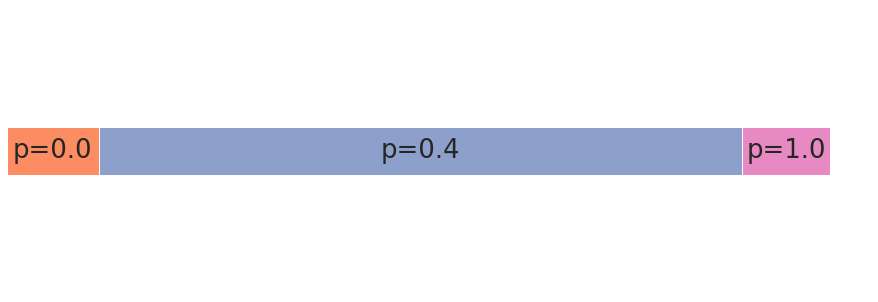

Recipes


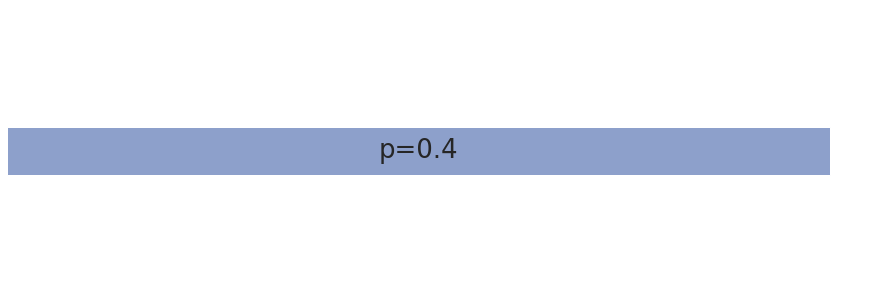

New York Times


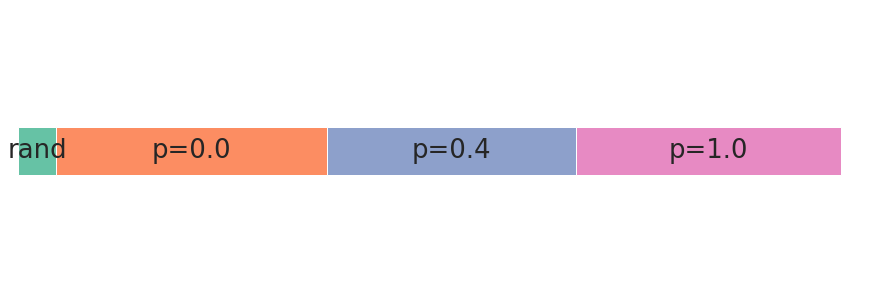

Presidential Speeches


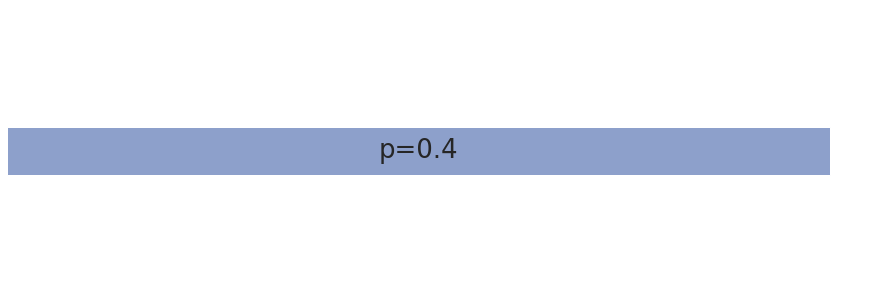

<AxesSubplot:>

In [37]:
def decide_label(i):
  v = float(values[i])
  if v >= 0:
    return "p={}".format(v)
  else:
    return "rand"

def plot(dataset):
  print(dataset)
  ax = plt.figure(figsize=[12, 4]).subplots(1, 1)

  df3 = df2[df2["dataset"]==dataset]
  ax = df3.plot(kind='barh', stacked=True, width=0.1, ax=ax)

  for i, c in enumerate(ax.containers):
    labels = [decide_label(i) if v.get_width() > 0.0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='center', fontsize=26)
  ax.get_legend().remove()
  plt.grid(False)
  plt.axis('off')
  plt.tight_layout()
  ax.set_position((0, 0, 1, 1))
  ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator())
  ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator())

  # plt.savefig("decoding_dist_{}.pdf".format(dataset.lower().replace(" ", "_")), transparent=True)
  plt.show()
  return ax

plot("Short Stories")
plot("Recipes")
plot("New York Times")
plot("Presidential Speeches")

## Models

In [38]:
df = full_df.groupby(['dataset', 'model']).count()
df = df.reset_index()

values = [-1, 0.0, 0.4, 1.0]

df2 = df.filter(items=["dataset", "model", "pk"])
df2 = df2.groupby(['dataset', 'model']).sum().unstack()
df2 = df2.fillna(0)
df2.columns = [str(a[-1]) for a in df2.columns.to_flat_index()]

sums = df2.sum(axis=1)
for col in set(df2.columns) - {"dataset"}:
  df2[col] = df2[col] / sums

models_per_dataset = {
 "New York Times": ["easy", "gpt2-xl", "human"],
 "Presidential Speeches": ["ctrl-Politics", "ctrl-nocode", "human"],
 "Recipes": ["finetuned", "gpt2-xl", "human"],
 "Short Stories": ["gpt2", "gpt2-xl", "human"]   
}


df2 = df2.reset_index()
df2

,dataset,ctrl-Politics,ctrl-nocode,davinci,easy,finetuned,gpt2,gpt2-xl,human
0,New York Times,0.000000,0.000000,0.000000,0.042781,0.000000,0.00000,0.852718,0.104501
1,Presidential Speeches,0.541882,0.337539,0.000000,0.000000,0.000000,0.00000,0.000000,0.120579
2,Recipes,0.000000,0.000000,0.000000,0.000000,0.668958,0.00000,0.234920,0.096121
3,Short Stories,0.000000,0.000000,0.014738,0.000000,0.000000,0.52254,0.299306,0.163416


Short Stories


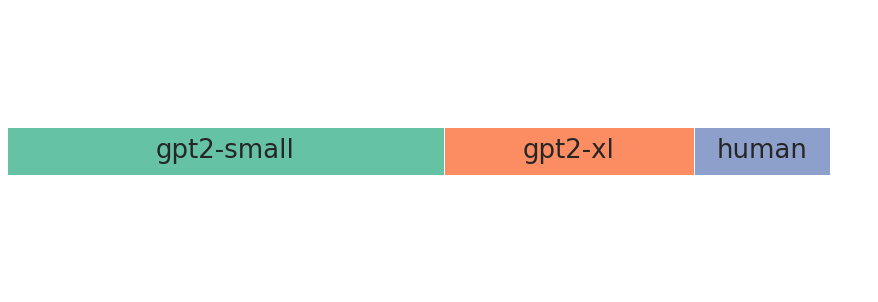

Recipes


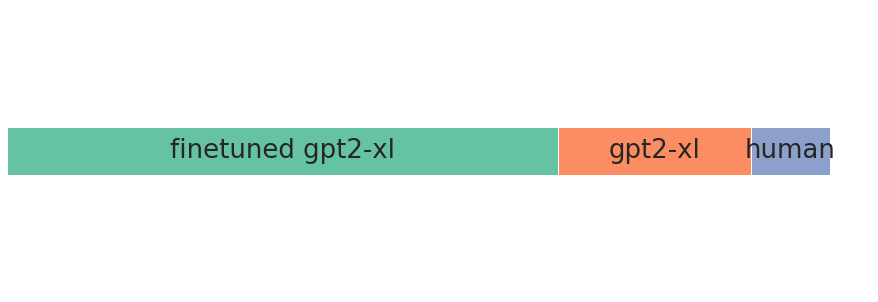

New York Times


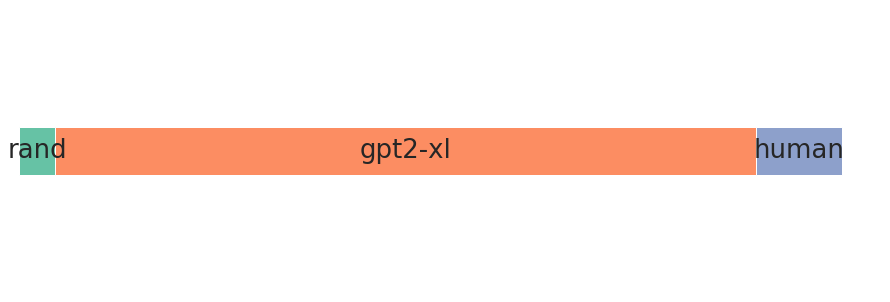

Presidential Speeches


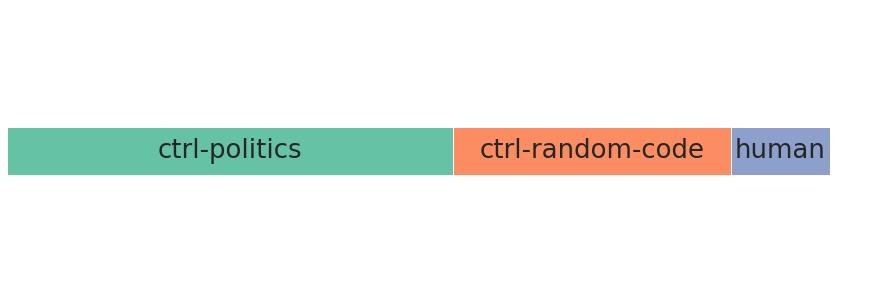

<AxesSubplot:>

In [39]:
def decide_label(dataset, i):
  name = models_per_dataset[dataset][i]

  name_remap = {
      "gpt2": "gpt2-small",
      "ctrl-nocode": "ctrl-random-code",
      "ctrl-Politics": "ctrl-politics",
      "finetuned": "finetuned gpt2-xl",
      "easy": "rand"
  }

  return name_remap.get(name, name)

def plot(dataset):
  print(dataset)
  ax = plt.figure(figsize=[12, 4]).subplots(1, 1)

  df3 = df2[df2["dataset"]==dataset][models_per_dataset[dataset]]
  ax = df3.plot(kind='barh', stacked=True, width=0.1, ax=ax)

  for i, c in enumerate(ax.containers):
    labels = [decide_label(dataset, i) if v.get_width() > 0.0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='center', fontsize=26)
  ax.get_legend().remove()
  plt.grid(False)
  plt.axis('off')
  plt.tight_layout()
  ax.set_position((0, 0, 1, 1))
  ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator())
  ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator())

  plt.savefig("model_dist_{}.pdf".format(dataset.lower().replace(" ", "_")), transparent=True)
  plt.show()
  return ax

plot("Short Stories")
plot("Recipes")
plot("New York Times")
plot("Presidential Speeches")

## Boundary Distributions

In [40]:
def plot_boundary_distribution(dataset, ax, df, dataset_name, boundary_name):

  boundaries = df[df[dataset_name]==dataset][boundary_name].tolist()
  boundaries = collections.Counter(boundaries)

  if boundary_name == "num_sentences":
    data = [boundaries.get(i) for i in range(1,11)]
    labels = range(1,11)
  else:
    data = [boundaries.get(i) for i in range(10)]
    labels = range(10)

  ax.pie(data, labels=labels, autopct='%.0f%%')
  ax.set_title(map_playlist_name(dataset))

In [41]:
df = generation_df
df["gen_pk"] = df["pk"]
df = df.join(prompt_df.set_index("pk"), on="prompt")

playlist_names = [] 
playlist_versions = []
for idx, row in df.iterrows():
  gen_id = row["gen_pk"]
  playlist_info = gen_to_playlist[gen_id]
  playlist_names.append(playlist_info[0])
  playlist_versions.append(playlist_info[1])
df["playlist_name"] = playlist_names
df["playlist_version"] = playlist_versions
df = df[df["playlist_version"] == "0.2"]

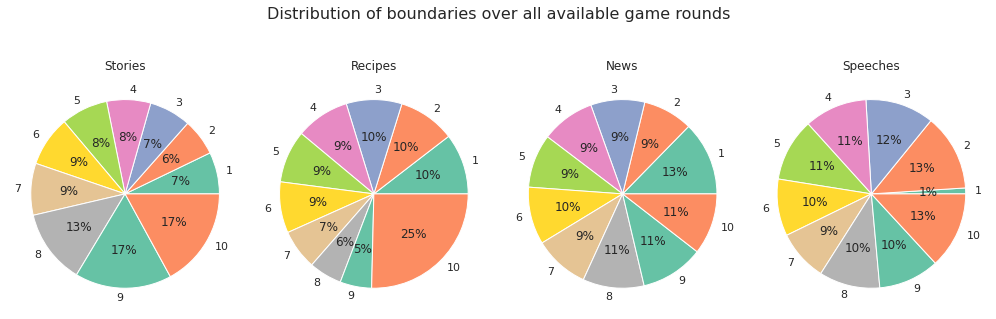

In [42]:
fig = plt.figure(figsize=[14, 5])
axes = fig.subplots(1, 4)
plot_boundary_distribution("Short Stories", axes[0], df, "playlist_name", "num_sentences")
plot_boundary_distribution("Recipes", axes[1], df, "playlist_name", "num_sentences")
plot_boundary_distribution("New York Times", axes[2], df, "playlist_name", "num_sentences")
plot_boundary_distribution("Presidential Speeches", axes[3], df, "playlist_name", "num_sentences")
fig.suptitle('Distribution of boundaries over all available game rounds', fontsize=16)
plt.tight_layout()
plt.savefig("available_game_rounds.pdf")
plt.show()

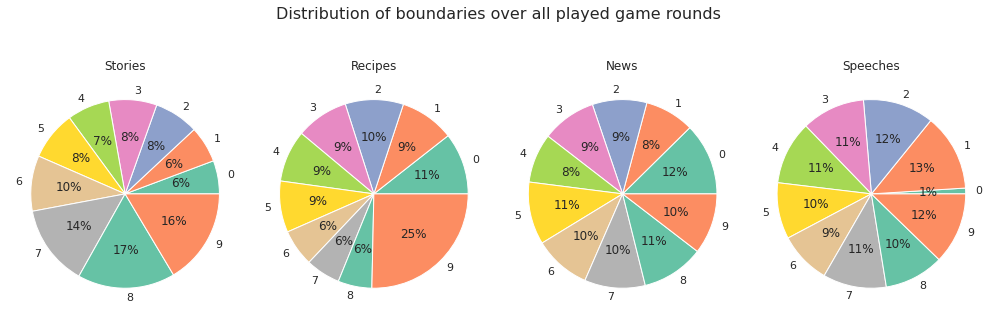

In [43]:
fig = plt.figure(figsize=[14, 5])
axes = fig.subplots(1, 4)
plot_boundary_distribution("Short Stories", axes[0], original_df, "dataset", "true_boundary_index")
plot_boundary_distribution("Recipes", axes[1], original_df, "dataset", "true_boundary_index")
plot_boundary_distribution("New York Times", axes[2], original_df, "dataset", "true_boundary_index")
plot_boundary_distribution("Presidential Speeches", axes[3], original_df, "dataset", "true_boundary_index")
fig.suptitle('Distribution of boundaries over all played game rounds', fontsize=16)
plt.tight_layout()
plt.savefig("played_game_rounds.pdf")
plt.show()

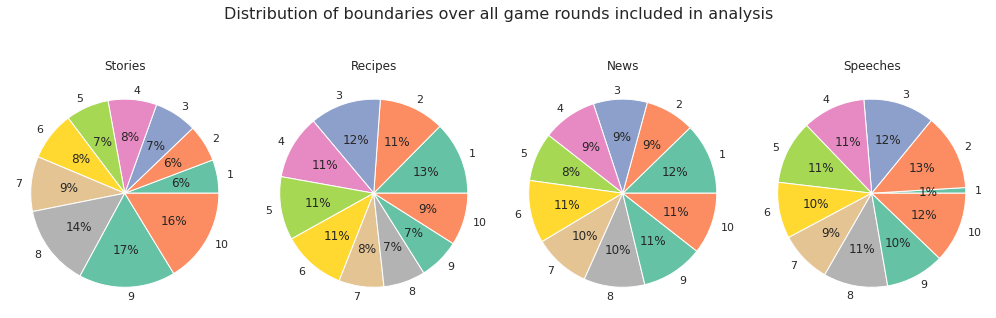

In [44]:
fig = plt.figure(figsize=[14, 5])
axes = fig.subplots(1, 4)
plot_boundary_distribution("Short Stories", axes[0], pre_cleaning_full_df, "playlist_name", "num_sentences")
plot_boundary_distribution("Recipes", axes[1], pre_cleaning_full_df, "playlist_name", "num_sentences")
plot_boundary_distribution("New York Times", axes[2], pre_cleaning_full_df, "playlist_name", "num_sentences")
plot_boundary_distribution("Presidential Speeches", axes[3], pre_cleaning_full_df, "playlist_name", "num_sentences")
fig.suptitle('Distribution of boundaries over all game rounds included in analysis', fontsize=16)
plt.tight_layout()
plt.savefig("analyzed_game_rounds.pdf")
plt.show()

## Histogram of Predicted Boundaries

<AxesSubplot:title={'center':'Index of Predicted Boundary (NYT) -- group 1'}, ylabel='Frequency'>

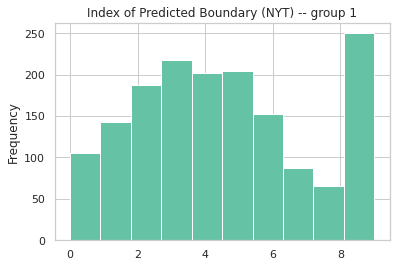

In [45]:
# full_df[full_df["dataset"] == "New York Times"].predicted_boundary_index.plot.hist(
#     title='Achieved Points Distribution (NYT)'
# )

full_df[(full_df["dataset"] == "New York Times") & (full_df['date'] < '2021-10-1') ].predicted_boundary_index.plot.hist(
    title='Index of Predicted Boundary (NYT) -- group 1'
)

<AxesSubplot:title={'center':'Index of Predicted Boundary (NYT) -- group 2'}, ylabel='Frequency'>

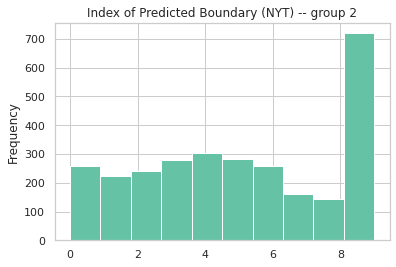

In [46]:
full_df[(full_df["dataset"] == "New York Times") & (full_df['date'] > '2021-10-1') ].predicted_boundary_index.plot.hist(
    title='Index of Predicted Boundary (NYT) -- group 2'
)

<AxesSubplot:title={'center':'Index of Predicted Boundary (Stories) -- group 1'}, ylabel='Frequency'>

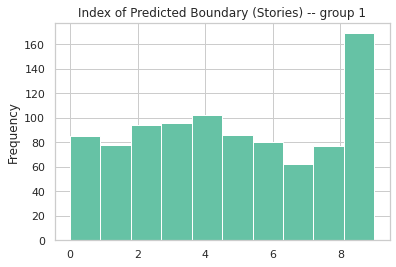

In [47]:
full_df[(full_df["dataset"] == "Short Stories") & (full_df['date'] < '2021-10-1') ].predicted_boundary_index.plot.hist(
    title='Index of Predicted Boundary (Stories) -- group 1'
)

<AxesSubplot:title={'center':'Index of Predicted Boundary (Stories) -- group 2'}, ylabel='Frequency'>

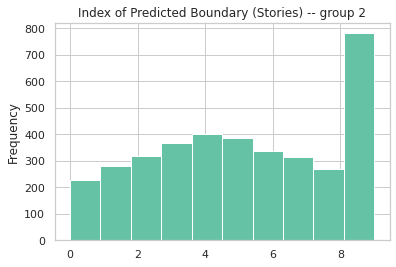

In [48]:
full_df[(full_df["dataset"] == "Short Stories") & (full_df['date'] > '2021-10-1') ].predicted_boundary_index.plot.hist(
    title='Index of Predicted Boundary (Stories) -- group 2'
)

<AxesSubplot:title={'center':'Index of Predicted Boundary (Speeches) -- group 1'}, ylabel='Frequency'>

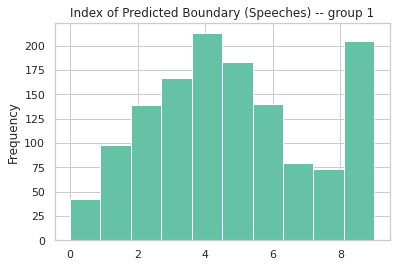

In [49]:
full_df[(full_df["dataset"] == "Presidential Speeches") & (full_df['date'] < '2021-10-1') ].predicted_boundary_index.plot.hist(
    title='Index of Predicted Boundary (Speeches) -- group 1'
)

<AxesSubplot:title={'center':'Index of Predicted Boundary (Speeches) -- group 2'}, ylabel='Frequency'>

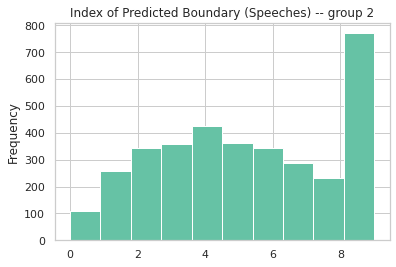

In [50]:
full_df[(full_df["dataset"] == "Presidential Speeches") & (full_df['date'] > '2021-10-1') ].predicted_boundary_index.plot.hist(
    title='Index of Predicted Boundary (Speeches) -- group 2'
)

<AxesSubplot:title={'center':'Index of Predicted Boundary (Recipes) -- group 1'}, ylabel='Frequency'>

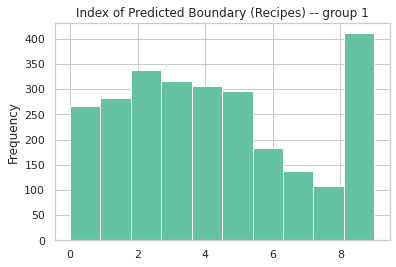

In [51]:
full_df[(full_df["dataset"] == "Recipes") & (full_df['date'] < '2021-10-1') ].predicted_boundary_index.plot.hist(
    title='Index of Predicted Boundary (Recipes) -- group 1'
)

<AxesSubplot:title={'center':'Index of Predicted Boundary (Recipes) -- group 2'}, ylabel='Frequency'>

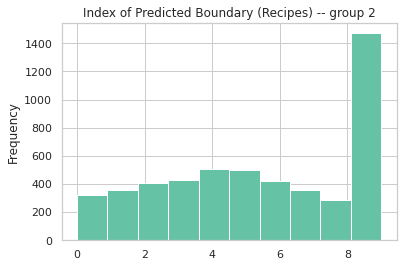

In [52]:
full_df[(full_df["dataset"] == "Recipes") & (full_df['date'] > '2021-10-1') ].predicted_boundary_index.plot.hist(
    title='Index of Predicted Boundary (Recipes) -- group 2'
)

# Final graphs for paper

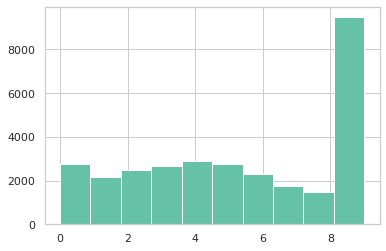

In [53]:
original_df[~original_df['annotator'].isin([4334])].predicted_boundary_index.plot.hist()
plt.ylabel('')
plt.savefig('histogram.pdf')

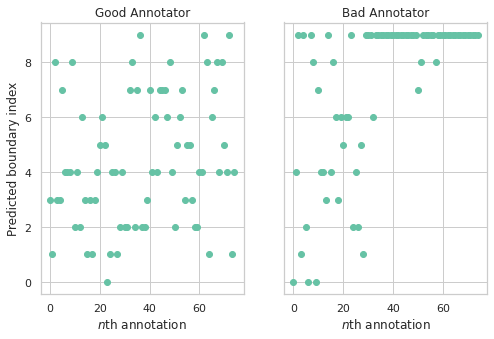

In [54]:
fig = plt.figure(figsize=[8, 5])
axes = fig.subplots(1, 2, sharey=True)
ys1 = original_df[original_df["annotator"] == 5409].sort_values("date")["predicted_boundary_index"].tolist()
ys2 = original_df[original_df["annotator"] == 5411].sort_values("date")["predicted_boundary_index"].tolist()
axes[0].scatter(x=range(75), y=ys1[:75])
axes[1].scatter(x=range(75), y=ys2[:75])
axes[0].set_title("Good Annotator")
axes[0].set(xlabel="$n$th annotation", ylabel="Predicted boundary index")
axes[1].set_title("Bad Annotator")
axes[1].set(xlabel="$n$th annotation")

plt.savefig("goodvsbad.pdf")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

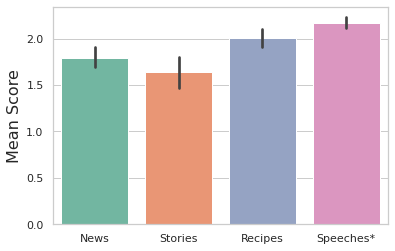

In [55]:
filtered_df = full_df[((full_df["model"]=="gpt2-xl") | (full_df["model"]=="ctrl-Politics") | (full_df["model"]=="ctrl-nocode")) & 
                      (full_df["dec_strat_value"]==0.4)]
filtered_df["model"] = filtered_df["model"].apply(lambda x: "ctrl" if "ctrl" in x else x)
filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)
filtered_df["dataset"] = filtered_df["dataset"].apply(map_playlist_name)
filtered_df["dataset"] = filtered_df["dataset"].apply(lambda x: "Speeches*" if "Speeches" in x else x)

# p = sns.barplot(x="dataset", y="points", data=filtered_df, order=["News", "Stories", "Recipes"])
p = sns.barplot(x="dataset", y="points", data=filtered_df, order=["News", "Stories", "Recipes", "Speeches*"])

p.set_title("")
p.set_xlabel("")

matplotlib.rc('xtick', labelsize=12) 
p.set_ylabel("Mean Score", fontsize = 16)
plt.savefig("genre.pdf")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


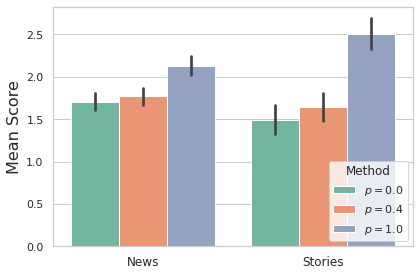

In [56]:
filtered_df = full_df[
                      (full_df["model"]=="gpt2-xl") & 
                      (full_df["dataset"]=="Short Stories") | (full_df["dataset"]=="New York Times") &
                      (full_df["dec_strat_value"] != -1)]
filtered_df["dataset"] = filtered_df["dataset"].apply(map_playlist_name)
filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)
p = sns.barplot(x="dataset", y="points", hue="dec_strat_value", data=filtered_df, hue_order=["$p=0.0$","$p=0.4$","$p=1.0$"])
# p.set_title("Comparison of Generation Performance of GPT2-XL across values of top-p")
p.set_xlabel("", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)
p.legend(loc="lower right").set_title("Method")
matplotlib.rc('xtick', labelsize=12) 
plt.tight_layout()
plt.savefig("topp.pdf")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


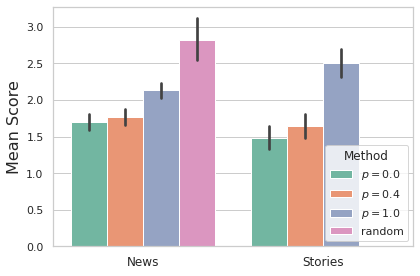

In [57]:
filtered_df = full_df[
                      (full_df["model"]=="gpt2-xl") & 
                      (full_df["dataset"]=="Short Stories") | (full_df["dataset"]=="New York Times")]
filtered_df["dataset"] = filtered_df["dataset"].apply(map_playlist_name)
filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)

order = ["$p=0.0$","$p=0.4$","$p=1.0$", "random"]
p = plt.figure(figsize=[6, 4]).subplots(1, 1)
p = sns.barplot(x="dataset", y="points", hue="dec_strat_value", data=filtered_df, hue_order=order, ax=p, )
p.set_xlabel("", fontsize=16)
p.set_ylabel("Mean Score", fontsize = 16)
# p.set_xticks(order, fontsize=16)
p.legend(loc="lower right").set_title("Method")
matplotlib.rc('xtick', labelsize=12) 

plt.tight_layout()
plt.savefig("topp_with_baseline.pdf")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


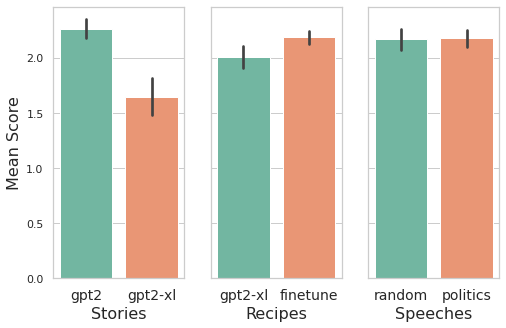

In [58]:
filtered_df = full_df[(full_df["dataset"]=="Short Stories") & 
                                     (full_df["dec_strat_value"]==0.4) & 
                                     (full_df["model"]!="davinci") & (full_df["model"] != "human")]
# plt.rcParams["figure.autolayout"] = True
matplotlib.rc('xtick', labelsize=14) 

fig = plt.figure(figsize=[8, 5])
axes = fig.subplots(1, 3, sharey=True)
p = sns.barplot(x="model", y="points", data=filtered_df, ax=axes[0])
p.set_title("")
p.set_xlabel("Stories", fontsize=16)
p.set_ylabel("Mean Score", fontsize=16)

filtered_df = full_df[(full_df["dataset"]=="Recipes") & (full_df["model"]!="human")]
filtered_df['to_plot'] = filtered_df['model'].apply(lambda x: 'finetune' if x == 'finetuned' else 'gpt2-xl')
p = sns.barplot(x="to_plot", y="points", data=filtered_df, ax=axes[1], order=["gpt2-xl", "finetune"])
p.set_title("")
p.set_xlabel("Recipes", fontsize=16)
p.set_ylabel("")

filtered_df = full_df[(full_df["dataset"]=="Presidential Speeches") & (full_df["model"]!="human")]
filtered_df['to_plot'] = filtered_df['model'].apply(lambda x: 'random' if x == 'ctrl-nocode' else 'politics')
p = sns.barplot(x="to_plot", y="points", data=filtered_df, ax=axes[2])
p.set_title("")
p.set_xlabel("Speeches", fontsize=16)
p.set_ylabel("")

plt.savefig("model_size_and_finetuning.pdf")
plt.show()

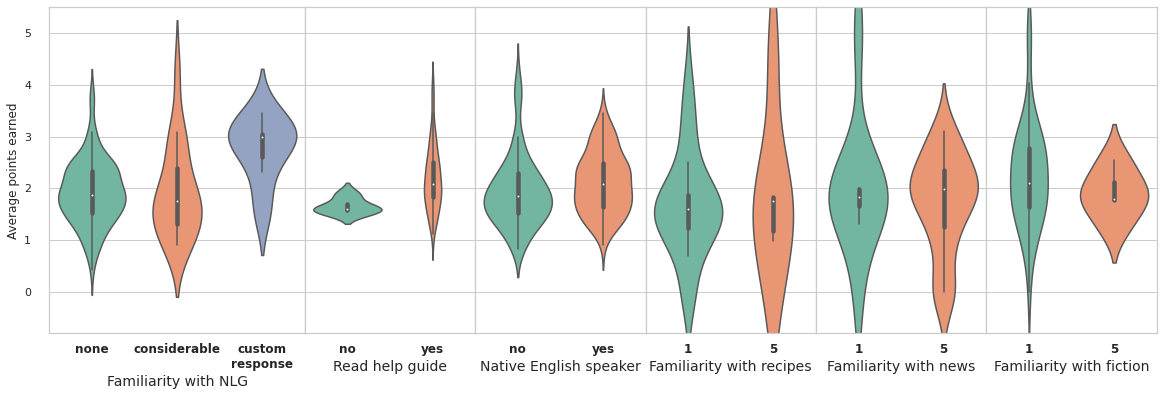

In [59]:
fig = plt.figure(figsize=[20, 6])
fig.tight_layout(pad=0)
width_ratios = [0.1, 3, 2, 2, 2, 2, 2]
axes = fig.subplots(1, len(width_ratios), sharey=True, gridspec_kw={'width_ratios': width_ratios})

ax = axes[0]
ax.set_ylim([-0.8, 5.5])
ax.set_ylabel("Average points earned")
ax.grid(visible=False)
ax.xaxis.set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.subplots_adjust(wspace=0)

# Familiarity
order = collections.OrderedDict([(1, "none"), (4, "considerable"), (-1, "custom\nresponse")])
df=full_df_freq10.groupby(["username", "gen_familiarity"]).points.mean().reset_index()
df = df[(df["gen_familiarity"] == -1) | (df["gen_familiarity"] == 1) | (df["gen_familiarity"] == 4)]
df["gen_familiarity"] = df["gen_familiarity"].apply(lambda x: order[x])
ax = sns.violinplot(x="gen_familiarity", y="points", data=df, order=order.values(), ax=axes[1])
ax.set_xticklabels(order.values(), fontsize=12, fontweight='bold')
ax.set_ylabel("")
ax.set_xlabel("Familiarity with NLG", fontsize=14)

# Read guide
order = collections.OrderedDict([("No", "no"), ("Yes", "yes")])
df = full_df_freq20[full_df_freq20["read_guide"] != ""]
df=df.groupby(["username", "read_guide"]).points.mean().reset_index()
df["read_guide"] = df["read_guide"].apply(lambda x: order[x])
ax = sns.violinplot(x="read_guide", y="points", data=df, order=order.values(), ax=axes[2])
ax.set_xticklabels(order.values(), fontsize=12, fontweight='bold')
ax.set_ylabel("")
ax.set_xlabel("Read help guide", fontsize=14)

# Native English speaker
df = full_df_freq20[full_df_freq20["english"] != ""]
df=df.groupby(["username", "english"]).points.mean().reset_index()
ax = sns.violinplot(x="english", y="points", data=df, ax=axes[3])
ax.set_xticklabels(order.values(), fontsize=12, fontweight='bold')
ax.set_ylabel("")
ax.set_xlabel("Native English speaker", fontsize=14)

# Recipe familiarity
order = [1, 5]
df = full_df_freq20[(full_df_freq20["recipe_familiarity"] == 1) | (full_df_freq20["recipe_familiarity"] == 5)]
df = df[df['dataset']=="Recipes"].groupby(["username", "recipe_familiarity"]).points.mean().reset_index()
ax = sns.violinplot(x="recipe_familiarity", y="points", data=df, ax=axes[4])
ax.set_xticklabels(order, fontsize=12, fontweight='bold')
ax.set_ylabel("")
ax.set_xlabel("Familiarity with recipes", fontsize=14)

# News familiarity
order = [1, 5]
df = full_df_freq20[(full_df_freq20["news_familiarity"] == 1) | (full_df_freq20["news_familiarity"] == 5)]
df = df[df['dataset']=="Recipes"].groupby(["username", "news_familiarity"]).points.mean().reset_index()
ax = sns.violinplot(x="news_familiarity", y="points", data=df, ax=axes[5])
ax.set_xticklabels(order, fontsize=12, fontweight='bold')
ax.set_ylabel("")
ax.set_xlabel("Familiarity with news", fontsize=14)

# Fiction familiarity
order = [1, 5]
df = full_df_freq20[(full_df_freq20["stories_familiarity"] == 1) | (full_df_freq20["stories_familiarity"] == 5)]
df = df[df['dataset']=="Recipes"].groupby(["username", "stories_familiarity"]).points.mean().reset_index()
ax = sns.violinplot(x="stories_familiarity", y="points", data=df, ax=axes[6])
ax.set_xticklabels(order, fontsize=12, fontweight='bold')
ax.set_ylabel("")
ax.set_xlabel("Familiarity with fiction", fontsize=14)

plt.savefig("survey_results.pdf")

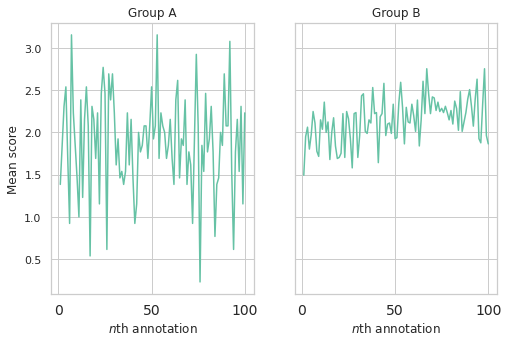

In [62]:
def analyze_progress(df, k=50):
  """Analyze whether annotators improve in aggregate over k annotations."""
  all_score_series = []
  annotators = df[df["pk"] > k].reset_index()["annotator"].tolist()
  for annotator in annotators:
    annotations = full_df[full_df["annotator"] == annotator]
    score_series = annotations.sort_values("date")["points"][:k].tolist()
    all_score_series.append(score_series)

  return np.array(all_score_series), len(annotators)

fig = plt.figure(figsize=[8, 5])
axes = fig.subplots(1, 2, sharey=True)
s1, n1 = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), 100)
s2, n2 = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), 100)

axes[0].plot(range(1, 100+1), np.mean(np.array(s1), axis=0))
axes[1].plot(range(1, 100+1), np.mean(np.array(s2), axis=0))
axes[0].set_title("Group A")
axes[0].set(xlabel="$n$th annotation", ylabel="Mean score")
axes[1].set_title("Group B")
axes[1].set(xlabel="$n$th annotation")

plt.savefig("overtime.pdf")
plt.show()

# Analysis

## Mean points

In [63]:
def analyze_per_playlist():
  info_to_return = []
  playlist_names = set(playlist_df["shortname"].tolist())
  model_names = set(full_df["model"].tolist())
  for playlist in playlist_names:
    for model in model_names:
      df = full_df[(full_df["dataset"]==playlist) & 
                          (full_df["model"]==model)]
      
      if len(df) > 0:
        info = {"playlist": playlist,
                "model": model,
                "mean score": np.mean(df["points"]),
                "median score": np.median(df["points"]),
                "std dev": np.std(df["points"]),
                "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
                "num_annotations": len(df)
        }
        info_to_return.append(info)
  return pd.DataFrame(info_to_return)

analyze_per_playlist()

,playlist,model,mean score,median score,std dev,fraction_nonzero,num_annotations
0,Presidential Speeches,human,1.989708,0.0,2.447366,0.397942,583
1,Presidential Speeches,ctrl-Politics,2.173664,2.0,2.058680,0.601527,2620
2,Presidential Speeches,ctrl-nocode,2.166667,2.0,2.046139,0.602328,1632
3,Recipes,human,2.290148,0.0,2.460653,0.465587,741
4,Recipes,gpt2-xl,2.004417,1.0,2.129694,0.542794,1811
5,Recipes,finetuned,2.183828,2.0,2.136406,0.576110,5157
6,Short Stories,human,1.823607,0.0,2.400691,0.367374,754
7,Short Stories,gpt2,2.262547,2.0,2.140329,0.570303,2411
8,Short Stories,gpt2-xl,1.866763,1.0,1.941111,0.557567,1381
9,Short Stories,davinci,1.764706,1.0,1.832048,0.617647,68


In [64]:
def analyze_per_decoding_strat():
  info_to_return = []
  playlist_names = set(playlist_df["shortname"].tolist())
  model_names = set(full_df["model"].tolist())
  model_names.remove('human')
  for playlist in playlist_names:
    for model in model_names:
      for top_p_value in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        df = full_df[(full_df["dec_strat_value"]==top_p_value) &
                  (full_df["dataset"]==playlist) &
                  (full_df["model"]==model)]

        if len(df) > 0:
          info = {"p-value": top_p_value,
                  "playlist": playlist,
                  "model": model,
                  "mean_score": np.mean(df["points"]),
                  "std_dev": np.std(df["points"]),
                  "median_score": np.median(df["points"]),
                  "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
                  "num_annotations": len(df),
          }
          info_to_return.append(info)
  return pd.DataFrame(info_to_return)

per_p_df = analyze_per_decoding_strat()
per_p_df

,p-value,playlist,model,mean_score,std_dev,median_score,fraction_nonzero,num_annotations
0,0.4,Presidential Speeches,ctrl-Politics,2.173664,2.058680,2.0,0.601527,2620
1,0.4,Presidential Speeches,ctrl-nocode,2.166667,2.046139,2.0,0.602328,1632
2,0.4,Recipes,gpt2-xl,2.004417,2.129694,1.0,0.542794,1811
3,0.4,Recipes,finetuned,2.183828,2.136406,2.0,0.576110,5157
4,0.4,Short Stories,gpt2,2.262547,2.140329,2.0,0.570303,2411
5,0.0,Short Stories,gpt2-xl,1.484009,1.805659,0.0,0.479744,469
6,0.4,Short Stories,gpt2-xl,1.645299,1.851956,1.0,0.523504,468
7,1.0,Short Stories,gpt2-xl,2.504505,2.011785,3.0,0.675676,444
8,0.4,Short Stories,davinci,1.764706,1.832048,1.0,0.617647,68
9,0.0,New York Times,gpt2-xl,1.680147,1.922748,1.0,0.502941,1360


In [65]:
def analyze_per_generation_length():
  info_to_return = []
  playlist_names = set(playlist_df["shortname"].tolist())
  model_names = set(full_df["model"].tolist())
  model_names.remove('human')
  for gen_len in range(10):
    df = full_df[(full_df["true_boundary_index"]==gen_len)]

    if len(df) > 0:
      info = {"true_boundary_index": gen_len,
              "mean_score": np.mean(df["points"]),
              "std_dev": np.std(df["points"]),
              "median_score": np.median(df["points"]),
              "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
              "num_annotations": len(df),
      }
      info_to_return.append(info)
  return pd.DataFrame(info_to_return)

per_p_df = analyze_per_generation_length()
per_p_df

,true_boundary_index,mean_score,std_dev,median_score,fraction_nonzero,num_annotations
0,0,1.948857,2.032006,1.0,0.567465,1838
1,1,2.165751,2.031348,2.0,0.618132,2184
2,2,2.288947,2.038163,2.0,0.641862,2298
3,3,2.288120,2.048415,2.0,0.621302,2197
4,4,2.212208,2.164279,2.0,0.565093,2097
5,5,2.169591,2.045486,1.0,0.663068,2223
6,6,1.907966,2.006886,2.0,0.541981,1858
7,7,1.929513,2.068196,0.0,0.490223,2199
8,8,1.957187,2.213170,0.0,0.444299,2289
9,9,1.934633,2.435233,0.0,0.386927,2463


### Comparison of XL models across p-values for NYT and Reddit

**Conclusion**: Sampling from full distribution (p=1.0) has worse quality. Argmax sampling (with repetition penalty) seems to be consistently better for text quality -- this is consistent with Daphne's research.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


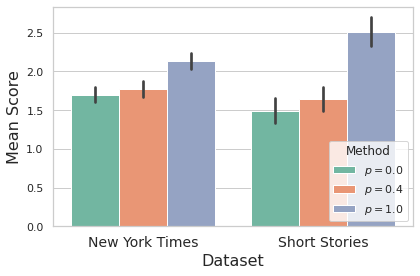

In [66]:
filtered_df = full_df[
                      (full_df["model"]=="gpt2-xl") & 
                      (full_df["dataset"]=="Short Stories") | (full_df["dataset"]=="New York Times") &
                      (full_df["dec_strat_value"] != -1)]

filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)
p = sns.barplot(x="dataset", y="points", hue="dec_strat_value", data=filtered_df, hue_order=["$p=0.0$","$p=0.4$","$p=1.0$"])
# p.set_title("Comparison of Generation Performance of GPT2-XL across values of top-p")
p.set_xlabel("Dataset", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)
p.legend(loc="lower right").set_title("Method")
plt.tight_layout()
plt.savefig("topp.pdf")

### Comparison of GPT2-XL p=0.4 across reddit, nyt, and recipes

**Conclusion:** We see that Recipes are the most difficult, then NYT and short stories. This shows that generation systems struggle with structured text and are better at more open-ended generations (?). Also shows that domain knowledge is important. (although NYT being better than reddit is interesting).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


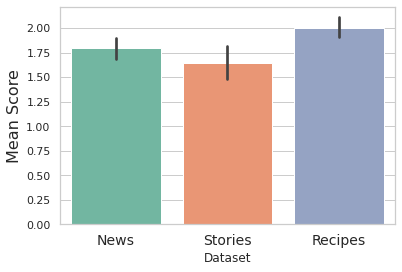

In [67]:
filtered_df = full_df[((full_df["model"]=="gpt2-xl")) & 
                                     (full_df["dec_strat_value"]==0.4)]

filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)
filtered_df["dataset"] = filtered_df["dataset"].apply(map_playlist_name)

p = sns.barplot(x="dataset", y="points", data=filtered_df, order=["News", "Stories", "Recipes"])
p.set_title("")
p.set_xlabel("Dataset")
p.set_ylabel("Mean Score", fontsize = 16)
plt.savefig("genre.pdf")

### Comparison of Model Size across same dataset and p-value

**Conclusion**: Bigger Models are better (good sanity check, nice to know this is confirmed) -- don't use GPT3 here because we only have 89 annotations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


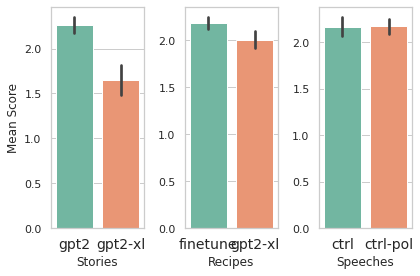

In [68]:
filtered_df = full_df[(full_df["dataset"]=="Short Stories") & 
                                     (full_df["dec_strat_value"]==0.4) & 
                                     (full_df["model"]!="davinci") & (full_df["model"] != "human")]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 3)
p = sns.barplot(x="model", y="points", data=filtered_df, ax=axes[0])
p.set_title("")
p.set_xlabel("Stories")
p.set_ylabel("Mean Score")

filtered_df = full_df[(full_df["dataset"]=="Recipes") & (full_df["model"]!="human")]
filtered_df['to_plot'] = filtered_df['model'].apply(lambda x: 'finetune' if x == 'finetuned' else 'gpt2-xl')
p = sns.barplot(x="to_plot", y="points", data=filtered_df, ax=axes[1])
p.set_title("")
p.set_xlabel("Recipes")
p.set_ylabel("")

filtered_df = full_df[(full_df["dataset"]=="Presidential Speeches") & (full_df["model"]!="human")]
filtered_df['to_plot'] = filtered_df['model'].apply(lambda x: 'ctrl' if x == 'ctrl-nocode' else 'ctrl-pol')
p = sns.barplot(x="to_plot", y="points", data=filtered_df, ax=axes[2])
p.set_title("")
p.set_xlabel("Speeches")
p.set_ylabel("")

plt.savefig("model_size_and_finetuning.pdf")
plt.show()

### Comparison of fine-tuning performance

Text(0, 0.5, 'Mean Score')

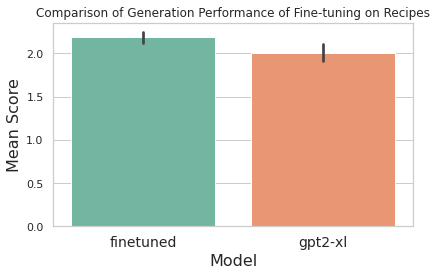

In [69]:
filtered_df = full_df[(full_df["dataset"]=="Recipes") & (full_df["model"]!="human")]

p = sns.barplot(x="model", y="points", data=filtered_df)
p.set_title("Comparison of Generation Performance of Fine-tuning on Recipes")
p.set_xlabel("Model", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)

Text(0, 0.5, 'Mean Score')

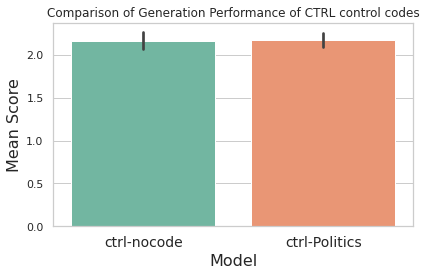

In [70]:
filtered_df = full_df[(full_df["dataset"]=="Presidential Speeches") & (full_df["model"]!="human")]

p = sns.barplot(x="model", y="points", data=filtered_df)
p.set_title("Comparison of Generation Performance of CTRL control codes")
p.set_xlabel("Model", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)

###Mean Points for users that have no familiarity with generated text vs. users that do

(-0.6, 5.5)

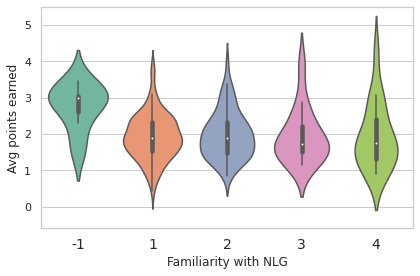

In [71]:
df_familiarity=full_df_freq10.groupby(["username", "gen_familiarity"]).points.mean().reset_index()
df_familiarity.rename({"gen_familiarity": "Familiarity with NLG", "points": "Avg points earned"}, axis=1, inplace=True)
sns.violinplot(x="Familiarity with NLG", y="Avg points earned", data=df_familiarity)
plt.ylim([-0.6, 5.5])

### Mean Points for native vs. non-native English speakers

(-0.6, 5.5)

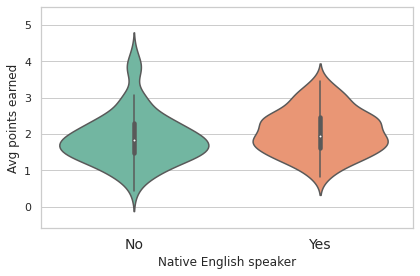

In [72]:
df_language=full_df_freq10.groupby(["username", "english"]).points.mean().reset_index()
df_language.rename({"english": "Native English speaker", "points": "Avg points earned"}, axis=1, inplace=True)
sns.violinplot(x="Native English speaker", y="Avg points earned", data=df_language)
plt.ylim([-0.6, 5.5])

###Mean points for users with familiarity in a given domain

(-0.6, 5.5)

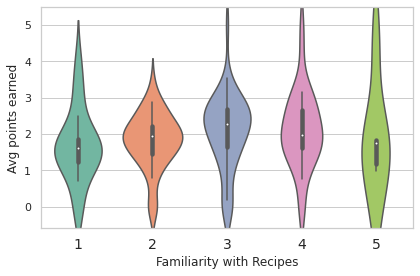

In [73]:
df_familiarity=full_df_freq20[full_df_freq20['dataset']=="Recipes"].groupby(["username", "recipe_familiarity"]).points.mean().reset_index()
df_familiarity.rename({"recipe_familiarity": "Familiarity with Recipes", "points": "Avg points earned"}, axis=1, inplace=True)
sns.violinplot(x="Familiarity with Recipes", y="Avg points earned", data=df_familiarity)
plt.ylim([-0.6, 5.5])

(-0.6, 5.5)

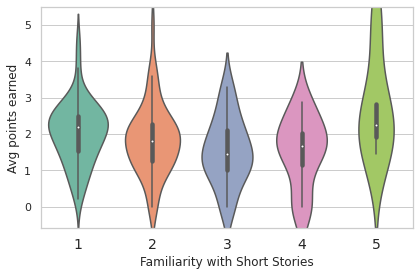

In [74]:
df_familiarity=full_df_freq20[full_df_freq20['dataset']=="Short Stories"].groupby(["username", "stories_familiarity"]).points.mean().reset_index()
df_familiarity.rename({"stories_familiarity": "Familiarity with Short Stories", "points": "Avg points earned"}, axis=1, inplace=True)
sns.violinplot(x="Familiarity with Short Stories", y="Avg points earned", data=df_familiarity)
plt.ylim([-0.6, 5.5])

(-0.6, 5.5)

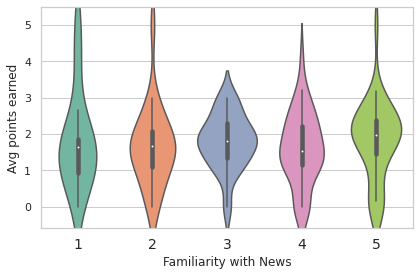

In [75]:
df_familiarity=full_df_freq20[full_df_freq20['dataset']=="New York Times"].groupby(["username", "news_familiarity"]).points.mean().reset_index()
df_familiarity.rename({"news_familiarity": "Familiarity with News", "points": "Avg points earned"}, axis=1, inplace=True)
sns.violinplot(x="Familiarity with News", y="Avg points earned", data=df_familiarity)
plt.ylim([-0.6, 5.5])

### Mean points for CIS majors vs. non-CIS majors

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(-0.6, 5.5)

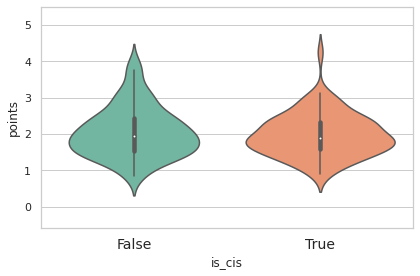

In [76]:
def is_cis_adjacent(x):
  cs_majors = ["CIS"]#, "MCIT", "CGGT", "CMPE", "ESE", "ROBO", "NETS", "DATS", "CBIO", "DMD", "SCMP"]
  return any([maj in list(x) for maj in cs_majors])
  
copied_df = full_df_freq20
copied_df['is_cis'] = full_df_freq20['major'].apply(is_cis_adjacent)
df_cis=copied_df.groupby(["username", "is_cis"]).points.mean().reset_index()
sns.violinplot(x="is_cis", y="points", data=df_cis)
plt.ylim([-0.6, 5.5])

### Mean points for those who read the guide and those who did not

(-0.6, 5.5)

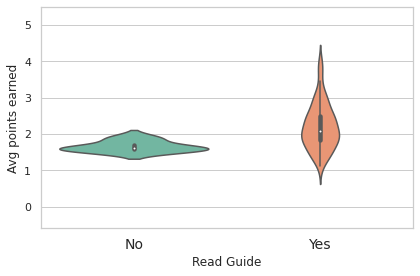

In [77]:
df_familiarity=full_df_freq20.groupby(["username", "read_guide"]).points.mean().reset_index()
df_familiarity.rename({"read_guide": "Read Guide", "points": "Avg points earned"}, axis=1, inplace=True)
sns.violinplot(x="Read Guide", y="Avg points earned", data=df_familiarity, order=["No", "Yes"])
plt.ylim([-0.6, 5.5])

## Reasoning behind annotation

We see that conditioning on grammar or generic-ness is least predictive. It's better to look for common sense, contradictions, or irrelevance. 

We also see that irrelevant makes up a very large percentage of all reported errors, suggesting that irrelevant generations are the biggest factor being picked up on by human annotators.

In [78]:
REASONS = ["grammar", "repetition", "irrelevant", "contradicts_sentence", "contradicts_knowledge", "common_sense", "coreference", "generic", "other"]

def is_reason(x, reason):
  return reason in list(x)
def is_other(x):
  return len(list(x)) != 0 and not any([r in list(x) for r in REASONS])

reason_df = copy.deepcopy(full_df)
#reason_df = reason_df[(reason_df["predicted_boundary_index"] >= reason_df["true_boundary_index"])]
for r in REASONS:
  reason_df[r] = full_df['reason'].apply(lambda x: is_reason(x, r))
reason_df["other"] = full_df['reason'].apply(is_other)

def analyze_per_reason():
  info_to_return = []
  for r in REASONS:
    df = reason_df[(reason_df[r]==True) & (reason_df["model"]!="easy") & (reason_df["model"]!="human") & (reason_df["model"]!="davinci")]
    
    if len(df) > 0:
      info = {"reason": r,
              "mean score": np.mean(df["points"]),
              #"median score": np.median(df["points"]),
              #"std dev": np.std(df["points"]), #TODO: switch to 95% confidence interval?
              #"fraction_nonzero": len(df[df["points"] > 0]) / len(df),
              "num_annotations": len(df)
      }
      info_to_return.append(info)
  return pd.DataFrame(info_to_return)

analyze_per_reason()

,reason,mean score,num_annotations
0,grammar,1.780377,1539
1,repetition,2.127747,728
2,irrelevant,2.530406,4259
3,contradicts_sentence,2.527397,1606
4,contradicts_knowledge,2.261517,1411
5,common_sense,2.566201,2432
6,coreference,2.249077,542
7,generic,1.920440,1546
8,other,2.040000,75


In [79]:
def isin(x,y):
  return x in y

def print_random_example_reason(reason, df):
  filtered_df = df
  df["isreason"] = df["reason"].apply(lambda x: is_reason(x, reason))
  df = df[df["isreason"]==True]
  sampled = filtered_df.sample(n=1)
  sents = sampled['gen_body'].tolist()[0].split("_SEP_")
  for i, s in enumerate(sents):
    print(s)

print_random_example_reason("repetition", full_df)

Serve at once.
You can also sprinkle with freshly grated Parmesan cheese and fresh lemon zest.
Variation: For another Italian version, add some diced tomatoes to the soup.
Omit the sage leaves and the sage.
The recipe is so good!
Add a cup of basil to the soup as well.
It's a pretty basic combination of flavors and colors and flavors.
I like the flavor will go nicely with the tomato, herbs and basil.
But it is good with goat cheese and cheeses.
This is just as simple and tasty.
Yummm is very good with crout everything.
The best served with pasta and the salad.
Try it.
I'm sure I don't know what I think this.
Just use a dollop them to be good for most anything.
This soup.
I think I would not taste it and is better, not that.
Have it tastes really be done.


In [80]:
def analyze_per_reason_model():
  info_to_return = []
  for r in REASONS:
    for model in set(full_df["model"].tolist()):
      df = reason_df[(reason_df[r]==True) & (reason_df["model"]==model)]
    
      if len(df) > 0:
        info = {"reason": r,
                "model": model,
                "mean score": np.mean(df["points"]),
                "median score": np.median(df["points"]),
                "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
                "num_annotations": len(df)
        }
        info_to_return.append(info)
  return pd.DataFrame(info_to_return)

analyze_per_reason_model()

# TODO: When people correctly gave the answer as machine generated (any sentence from machine)

# model_names = set(full_df["model"].tolist())
#   model_names.remove('human')
#   for playlist in playlist_names:
#     for model in model_names:
#       for top_p_value in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
#         df = full_df[(full_df["dec_strat_value"]==top_p_value) &
#                   (full_df["dataset"]==playlist) &
#                   (full_df["model"]==model)]

,reason,model,mean score,median score,fraction_nonzero,num_annotations
0,grammar,human,0.184834,0.0,0.037915,211
1,grammar,gpt2,2.099359,1.5,0.528846,312
2,grammar,ctrl-Politics,1.718563,0.0,0.449102,167
3,grammar,easy,2.000000,1.0,0.538462,13
4,grammar,gpt2-xl,1.794915,0.0,0.494915,590
...,...,...,...,...,...,...
66,other,ctrl-Politics,2.666667,3.0,0.666667,15
67,other,easy,0.000000,0.0,0.000000,1
68,other,gpt2-xl,1.812500,1.0,0.531250,32
69,other,finetuned,1.461538,0.0,0.384615,13


## Point Distributions

### Per playlist

In [81]:
import collections

In [82]:
df = full_df[full_df["model"].isin(('ctrl-Politics', 'ctrl-nocode', 'finetuned', 'gpt2-xl'))]
df = df[df["dec_strat_value"] == 0.4]

playlists = set(df["dataset"].tolist())
to_plot = []
for playlist in playlists:
  points = df[df["dataset"]==playlist].points.tolist()
  points = collections.Counter(points)

  heights = np.array(list(points.values())) / sum(points.values())
  for point_value, height in zip(points, heights):
    to_plot.append({"Points earned": point_value,
                    "Fraction of annotations":height,
                    "Domain": map_playlist_name(playlist)})

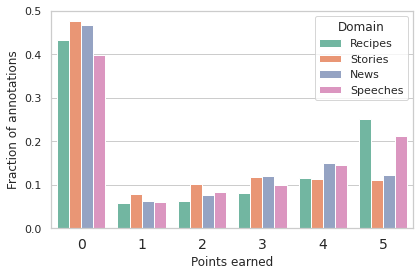

In [83]:
to_plot = pd.DataFrame(to_plot)
sns.barplot(x="Points earned", y="Fraction of annotations", hue="Domain", data=to_plot)
save("point_distribution.pdf")

### Per annotator

<AxesSubplot:title={'center':'Achieved Points Distribution'}, ylabel='Frequency'>

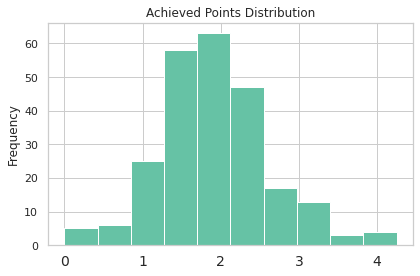

In [84]:
full_df.groupby('annotator').points.mean().plot.hist(
    title='Achieved Points Distribution'
)

## Find top annotators
These are annotators who got in the top quartile of annotators who did at least 10 annotations.

In [85]:
def find_top_annotators(df, min_n=10):
  """Analyze whether annotators improve in aggregate over k annotations."""
  
  annotators_and_points = []

  for annotator in set(df["annotator"].tolist()):
    points = df[df["annotator"] == annotator]["points"].tolist()
    
    if len(points) >= min_n:
      annotators_and_points.append((annotator, np.mean(points)))

  df = pd.DataFrame(annotators_and_points, columns=["annotator", "points"])
  quintile = np.quantile(df.points.tolist(), 0.75)
  print(quintile)
  df = df[df["points"] >= quintile]
  print(len(df))

  return df
top_annotators_df = find_top_annotators(full_df, 1)

2.3333333333333335
61


These are the annotators who did at least 50 annotations

In [86]:
def find_frequent_annotators(df, min_count):  
  annotators_and_points = []

  for annotator in set(df["annotator"].tolist()):
    points = df[df["annotator"] == annotator]["points"].tolist()
    
    if len(points) >= 20:
      annotators_and_points.append((annotator, np.mean(points), len(points)))

  df = pd.DataFrame(annotators_and_points, columns=["annotator", "points", "count"])
  print(len(df))

  return df
freq20_annotators_df = find_frequent_annotators(full_df, 20)
freq50_annotators_df = find_frequent_annotators(full_df, 50)

193
193


## Find bad annotators

In [87]:
full_df["predicted_boundary_index"]
full_df.groupby('annotator').sum()

,generation,predicted_boundary_index,points,prompt,true_boundary_index,prompt_index,dec_strat_value,recipe_familiarity,news_familiarity,stories_familiarity,gen_familiarity,isreason
annotator,,,,,,,,,,,,
1661,605198,135,52,441774,176,15390,13.6,136,102,68,34,2
1666,402845,72,29,282655,96,113031,6.8,34,51,85,34,1
1682,101141,7,6,64344,22,18643,2.4,12,30,24,6,2
1699,1484161,553,128,1109441,403,337404,33.6,344,344,344,172,1
1700,122628,50,28,85711,67,26670,5.0,60,45,30,30,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5505,1747754,512,262,1261044,507,369582,43.8,212,318,424,106,3
5506,757277,219,80,540445,190,64367,16.4,135,225,90,45,0
5540,1838774,763,176,1238811,513,210824,45.2,116,232,116,116,2


In [88]:
def find_problematic_annotators(df):
  """Analyze whether annotators improve in aggregate over k annotations."""
  
  too_many_same_df = []

  for annotator in set(df["annotator"].tolist()):
    guesses = df[df["annotator"] == annotator]["predicted_boundary_index"].tolist()
    
    # Check of they almost always guessed the same boundary
    modal_guess = scipy.stats.mode(guesses)
    fraction_modal = modal_guess.count[0] / len(guesses)
    if fraction_modal > 0.9:
      too_many_same_df.append((annotator, modal_guess, fraction_modal, len(guesses)))

  return pd.DataFrame(
      too_many_same_df, columns=["annotator", "guess", "fractional_model", "num_annotations"])
df = find_problematic_annotators(full_df)
df

,annotator,guess,fractional_model,num_annotations
0,2707,"([0], [1])",1.0,1


## Annotator performance over time

Of the annotators who did at least K annotations, plot their mean score over time

In [89]:
def analyze_progress(df, k=50):
  """Analyze whether annotators improve in aggregate over k annotations."""
  all_score_series = []
  annotators = df[df["pk"] > k].reset_index()["annotator"].tolist()
  for annotator in annotators:
    annotations = full_df[full_df["annotator"] == annotator]
    score_series = annotations.sort_values("date")["points"][:k].tolist()
    all_score_series.append(score_series)

  return np.array(all_score_series), len(annotators)

In [90]:
def analyze_and_plot(s, n, k, title=''):
  print(n)
  data = np.array(s)
  data = np.mean(data, axis=0)
  print("spearmanr: %.2f, %f" % stats.spearmanr(range(k), data))
  print("pearsonr: %.2f, %f" % stats.pearsonr(range(k), data))
  plt.plot(range(1, k+1), data)
  plt.ylabel("Mean score")
  plt.xlabel("$n$th annotation")
  plt.title("Performance over time")
  if title:
    plt.savefig(title)
  plt.show()

### Analysis of annotators getting better over time (1st Batch)

**Conclusion**: We see no correlation on the first batch of annotators. They do not improve over time

22
spearmanr: -0.03, 0.824170
pearsonr: -0.04, 0.759165


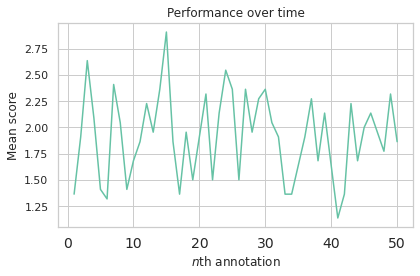

In [91]:
k = 50
s, n = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

13
spearmanr: -0.06, 0.521924
pearsonr: -0.05, 0.613787


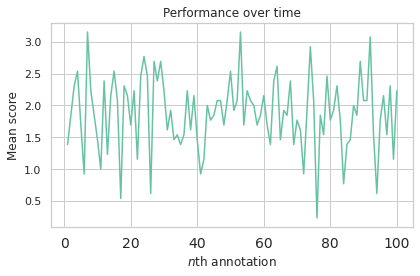

In [92]:
k = 100
s, n = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k, "overtimeb1.pdf")

In [93]:
# k = 200
# s, n = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), k)
# analyze_and_plot(s, n, k)

### Analysis of annotators getting better over time (2nd Batch)

**Conclusion**: We actually see a positive correlation (over 0.3) for k=50, 100, and 200 on the second batch of annotators. They DO actually improve over time. This suggests that, with the correct instructions, annotators may be able to be taught how to improve at detecting generated text.

88
spearmanr: 0.29, 0.043396
pearsonr: 0.30, 0.032424


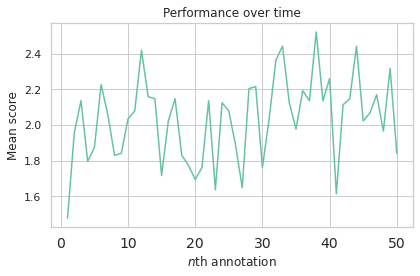

In [94]:
k = 50
s, n = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

81
spearmanr: 0.42, 0.000012
pearsonr: 0.44, 0.000006


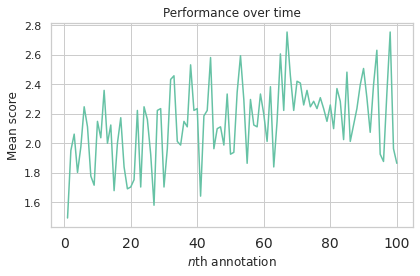

In [95]:
k = 100
s, n = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k, "overtimeb2.pdf")

19
spearmanr: 0.06, 0.387149
pearsonr: 0.06, 0.381428


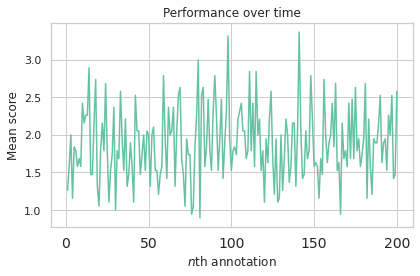

In [96]:
k = 200
s, n = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

## Inter-annotator agreement

### Difference in abilities

In [97]:
def analyze_ability_differences(df, k=50):
  """Analyze whether annotators improve in aggregate over k annotations."""
  df = df.groupby('annotator').count()
  all_score_series = []
  annotators = df[df["pk"] >= k].reset_index()["annotator"].tolist()
  for annotator in annotators:
    annotations = full_df[full_df["annotator"] == annotator]
    score_series = annotations.sort_values("date")["points"][:k].tolist()
    all_score_series.append(score_series)
    
  return all_score_series

In [98]:
scores = analyze_ability_differences(full_df, 50)
sum_scores = [sum(s) for s in scores]

In [99]:
print("Mean score:", np.mean(sum_scores))
print("Std score:", np.std(sum_scores))

Mean score: 100.91891891891892
Std score: 27.129364807663663


In [100]:
df = full_df.groupby('annotator').count()
annotators = df[df["pk"] >= 50].reset_index()["annotator"].tolist()

df = full_df[full_df["annotator"].isin(annotators)]
df = df.groupby('annotator').sum()
# df = annotation_df.groupby('generation').boundary.apply(list).reset_index()
# df = df[df.apply(lambda row: len(row["boundary"]) >= 4, axis=1)]

### Fraction agreement
For every pair of annotators who annotated the same generaton, what fraction guessed the same boundary?

In [101]:
annotations_per_gen = annotation_df.groupby('generation')
num_annotations_per_gen = annotations_per_gen.points.count()

In [102]:
def analyze_fraction_agreements():
  generation_ids = set(full_df["generation"].tolist())
  annotations_per_gen = full_df.groupby('generation')

  overall_num_annotations = 0
  overall_num_agreements = 0

  x = annotations_per_gen.predicted_boundary_index.value_counts()
  for idx, generation in enumerate(generation_ids):
    chosen_boundaries = x[generation]
    chosen_boundaries = {k: chosen_boundaries[k] for k in chosen_boundaries.keys()}
    
    total_annotations = sum(chosen_boundaries.values())
    if total_annotations > 1:
      total_agreements = sum(v for v in chosen_boundaries.values() if v > 1)

      overall_num_annotations += total_annotations
      overall_num_agreements += total_agreements

  print("Out of {} total annotations on generations with >1 annotation, {} were in agreement with another annotation on the true boundary position. That is {}".format(
      overall_num_annotations, overall_num_agreements, overall_num_agreements/overall_num_annotations
  ))
analyze_fraction_agreements()

# TODO: Figure out what the baseline of random guessing would be,

Out of 20109 total annotations on generations with >1 annotation, 9191 were in agreement with another annotation on the true boundary position. That is 0.45705902829578793


### Krippendorf's Alpha

In [103]:
import nltk.metrics

In [104]:
from nltk.metrics.agreement import AnnotationTask

In [105]:
# Get all game rounds for which there were 4 or more annotations.
df = full_df.groupby('generation').predicted_boundary_index.apply(list).reset_index()
df = df[df.apply(lambda row: len(row["predicted_boundary_index"]) >= 4, axis=1)]

In [106]:
def build_annotation_task(df):
  annotation_data = []
  for idx, row in df.iterrows():
    coder = row["annotator"]
    item = row["generation"]
    label = row["predicted_boundary_index"]
    annotation_data.append((coder,item,label))
  ann_task = AnnotationTask(annotation_data)
  return ann_task

def build_binary_annotation_task(df):
  annotation_data = []
  for idx, row in df.iterrows():
    coder = row["annotator"]
    item = row["generation"]
    label = row["predicted_boundary_index"] >= row["true_boundary_index"]
    annotation_data.append((coder,item,label))
  ann_task = AnnotationTask(annotation_data)
  return ann_task

Main set of annotations we are using or analyses

In [107]:
print(len(full_df))
ann_task = build_binary_annotation_task(full_df)
print(ann_task.alpha())

21646
-0.24954327431908396


Annotations before any filtering

In [108]:
print(len(full_df))
ann_task = build_binary_annotation_task(original_df)
print(ann_task.alpha())

21646
-0.14141710937836405


Annotations excluding the ones for all human models

In [109]:
df = full_df[full_df["model"] != "human"]
print(len(df))
ann_task = build_binary_annotation_task(df)
print(ann_task.alpha())

19099
-0.24994591747527584


Annotators who are in the top 25th percentile

In [110]:
df = full_df[full_df["annotator"].isin(top_annotators_df["annotator"])]
print(len(df))
ann_task = build_binary_annotation_task(df)
print(ann_task.alpha())

5444
0.2503977538738299


In [111]:
df = full_df[full_df["annotator"].isin(freq50_annotators_df["annotator"])]
print(len(df))
ann_task = build_binary_annotation_task(df)
print(ann_task.alpha())

top_annotators_df

21024
-0.2847858476609062


,annotator,points
0,4610,2.469388
1,2055,2.405405
2,2056,2.986111
5,4627,2.843931
7,4630,2.437186
...,...,...
222,5068,2.772727
223,4558,2.766667
232,4586,2.492537
233,2027,3.300000


## Profile Statistics

In [112]:
def user_stats(df, name):
  data = {"name": name}
  data["num_participants"] = len(np.unique(df["annotator"]).tolist())
  data["num_annotations"] = len(df)
  data["mean_annotations_per_participant"] = data["num_annotations"] / data["num_participants"] 
  data["mean_points"] = np.mean(df["points"])
  data["std_points"] = np.std(df["points"])
  return data

In [113]:
all_data = []
all_data.append(user_stats(full_df, "overall"))
all_data.append(user_stats(full_df[(full_df['date'] <= '2021-10-1')], "Section A"))
all_data.append(user_stats(full_df[(full_df['date'] > '2021-10-1')], "Section B"))

In [114]:
pd.DataFrame(all_data)

,name,num_participants,num_annotations,mean_annotations_per_participant,mean_points,std_points
0,overall,241,21646,89.817427,2.083249,2.124356
1,Section A,141,6527,46.290780,1.966294,2.124174
2,Section B,102,15119,148.225490,2.133739,2.122444


# Time Tracking Analysis
TODO: double check that timestamps are properly merged with the correct annotations. Also find a better way to calculate time delta than shift down by 1 and filter.

In [115]:
timing_df = get_df('core.timestamp')
timing_df = timing_df.rename(columns={'date': 'timestamp'}).merge(full_df, left_on='annotation', right_on='pk')

In [116]:
timing_df['timestamp'] = pd.to_datetime(timing_df.timestamp)
timing_df['delta'] = timing_df.timestamp - timing_df.timestamp.shift(1)
timing_df['delta'] = timing_df.delta.dt.components.milliseconds / 1000.0 + timing_df.delta.dt.components.seconds + timing_df.delta.dt.components.minutes * 60.0
timing_df = timing_df[timing_df.delta < 120] # TODO: Do this more properly instead of shift and filter

## Median Time Delta

In [117]:
timing_df.delta.median()

2.884

In [118]:
print(timing_df[timing_df['date'] <= '2021-10-1'].delta.mean())
print(timing_df[timing_df['date'] <= '2021-10-1'].delta.std())
print(timing_df[timing_df['date'] > '2021-10-1'].delta.mean())
print(timing_df[timing_df['date'] > '2021-10-1'].delta.std())
print(timing_df.delta.mean())
print(timing_df.delta.std())

5.651168933623522
10.877350684971523
6.4431870116321575
11.136243208397566
6.337851093081545
11.105368026413997


## Correlation Between Time Delta and Decoding Hyperparameter (top-p)

In [119]:
timing_df[['dec_strat_value', 'delta']].corr()

,dec_strat_value,delta
dec_strat_value,1.000000,-0.002007
delta,-0.002007,1.000000


## Time Delta Distribution

<AxesSubplot:>

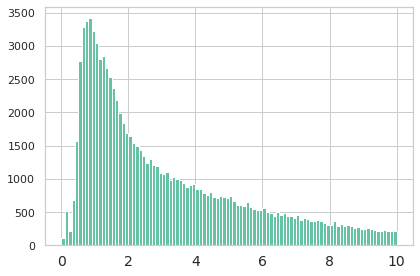

In [120]:
timing_df.delta.hist(bins=100, range=(0,10))
#plot( kind='hist',    range=(0, 60),    bins=30,    figsize=(20, 10),    title=('Turn Duration Distribution (seconds)')  )

## Correlation Between Time Delta and Sentence Length

In [121]:
timing_df['gen_body_length'] = timing_df.gen_body.str.len()
timing_df.groupby('annotation').agg({'delta': 'sum', 'gen_body_length': 'mean'}).corr()

,delta,gen_body_length
delta,1.000000,-0.090519
gen_body_length,-0.090519,1.000000


## Correlation Between Time Delta and Points

In [122]:
timing_df.groupby('annotation').agg({'delta': 'sum', 'points': 'mean'}).corr()

,delta,points
delta,1.000000,0.131878
points,0.131878,1.000000


## Comparison of Average Time Deltas Between Text Domains

<AxesSubplot:xlabel='dataset', ylabel='delta'>

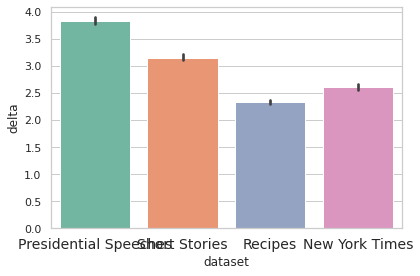

In [123]:
# Median
sns.barplot(y='delta', x='dataset', data=timing_df, estimator=np.median)#.groupby('dataset').agg({'delta': 'median'}).plot.bar()

<AxesSubplot:xlabel='dataset', ylabel='delta'>

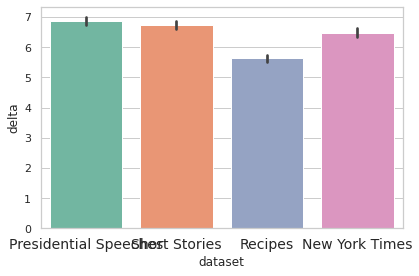

In [124]:
# Mean
sns.barplot(y='delta', x='dataset', data=timing_df)

## Comparison of Average Time Deltas Between Models

<AxesSubplot:xlabel='model', ylabel='delta'>

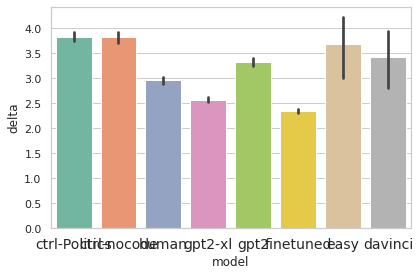

In [125]:
# Median
sns.barplot(y='delta', x='model', data=timing_df, estimator=np.median)

<AxesSubplot:xlabel='model', ylabel='delta'>

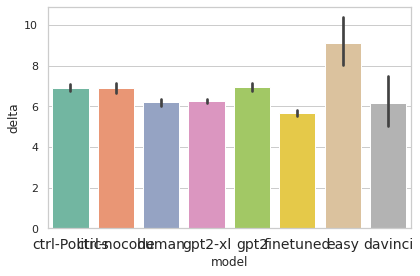

In [126]:
# Mean
sns.barplot(y='delta', x='model', data=timing_df)

## Do annotators get faster or slower over time?



In [127]:
#TODO

## Do annotators take longer to select their boundary sentence?


In [128]:
#TODO